In [2]:
# miscellaneous
import matplotlib.pyplot as plt

from glob import glob #library that helps us search for files
import scipy
import random
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from scipy.special import inv_boxcox
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# preprocessing
from category_encoders import OneHotEncoder,TargetEncoder,OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, PowerTransformer,LabelEncoder, MaxAbsScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score,cross_val_predict, KFold, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, PowerTransformer,LabelEncoder, MaxAbsScaler, RobustScaler

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression,BayesianRidge, ElasticNet, Lasso
from sklearn.dummy import DummyClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier, VotingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone
import lightgbm as lgb

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import log_loss, confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils.validation import check_is_fitted

# feature selection / data sampling
from sklearn.feature_selection import RFE, SelectKBest, f_classif, SelectFromModel, VarianceThreshold
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.inspection import permutation_importance

# saving model
import pickle,joblib
import boto3

# data settings
pd.pandas.set_option('display.max_rows',None)
pd.pandas.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', None)


from sklearn import set_config
set_config(transform_output = 'pandas')

import warnings
warnings.simplefilter(action="ignore")


import json

# custom package
import importlib
import package
importlib.reload(package)

from package.data_retrieval.data_retrieval import s3_retrieval, write_to_s3
from package.eda.data_exploration import correlation
from package.training.model_training import model_evaluation, split_data_by_type
from package.preprocessing.data_preprocessing import create_pipeline, winsorize, percentile_imputer, random_sample_imputer, count_encoder 

# Read Config

In [3]:
config_path = "C:/Users/Oamen/OneDrive/Documents/DATA PROJECTS/Insurance_claim_prediction_porto/config.json"

In [4]:
# Opening JSON file
with open(config_path) as file:
    
    config = json.load(file)

In [5]:
config['EDA']['config_path'] = config_path

# Read Data

In [6]:
# get access key
secret = pd.read_csv("C:/Users/Oamen/Downloads/jupyter_iam_accessKeys.csv")

In [7]:
# create S3 client object 
s3_client = boto3.client('s3',aws_access_key_id=secret['Access key ID'][0],aws_secret_access_key=secret['Secret access key'][0])

In [8]:
bucket_name = config['EDA']['bucket_name'] 

full_train_key = config['EDA']['full_train_path'] 
test_key = config['EDA']['test_path'] 
validation_key = config['EDA']['validation_path'] 
red_train_key = config['EDA']['red_train_path']

In [9]:
full_train = s3_retrieval(s3_client, bucket_name, full_train_key)

Retrieved object
Read bytes
Success!


In [10]:
test = s3_retrieval(s3_client, bucket_name, test_key)

Retrieved object
Read bytes
Success!


In [11]:
validation = s3_retrieval(s3_client, bucket_name, validation_key)

Retrieved object
Read bytes
Success!


In [12]:
reduced_train = s3_retrieval(s3_client, bucket_name, red_train_key)

Retrieved object
Read bytes
Success!


In [13]:
categorical_columns = config['EDA']['categorical_columns'] 

numerical_columns = config['EDA']['numerical_columns'] 

target = config['EDA']['target']

all_columns = categorical_columns + numerical_columns + [target]

In [14]:
# filter data

reduced_train = reduced_train[all_columns]
full_train = full_train[all_columns]
validation = validation[all_columns]
test = test[all_columns]

In [15]:
# set discrete to integer dtype

for column in categorical_columns:
    
    reduced_train[column] = reduced_train[column].apply(lambda x: x if pd.isnull(x) else str(x))
    full_train[column] = full_train[column].apply(lambda x: x if pd.isnull(x) else str(x))
    validation[column] = validation[column].apply(lambda x: x if pd.isnull(x) else str(x))
    test[column] = test[column].apply(lambda x: x if pd.isnull(x) else str(x))

In [16]:
reduced_train[:1]

,ps_ind_01,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_09,ps_calc_12,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_ind_03,ps_ind_15,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_06_cat,ps_car_11_cat,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_08,ps_calc_10,ps_calc_11,ps_calc_13,ps_calc_14,target
0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.8,1.0,NaN,0.0,NaN,1.0,1.0,2.0,1.0,3.0,0.5,0.7,0.2,3.0,4.0,8.0,5.0,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,7.0,0.5,1.040132,7.0,1.0,64.0,0.316228,0.610209,0.361939,2.828427,9.0,11.0,7.0,6.0,8.0,0.0


In [17]:
config['Model_Selection'] = {}
config['Model_Selection']['input_features'] = all_columns

# Save changes to data

In [177]:
config['Model_Selection']['Input_data'] = {}

full_train_new_key = 'model_selection/input_data/full_train.csv'
reduced_train_new_key = 'model_selection/input_data/reduced_train.csv'
validation_new_key = 'model_selection/input_data/validation.csv'
test_new_key = 'model_selection/input_data/test.csv'


config['Model_Selection']['Input_data']['full_train'] = full_train_new_key
config['Model_Selection']['Input_data']['reduced_train'] = reduced_train_new_key
config['Model_Selection']['Input_data']['validation'] = validation_new_key
config['Model_Selection']['Input_data']['test'] = test_new_key

In [181]:
write_to_s3(reduced_train, s3_client, bucket_name, reduced_train_new_key)

Success!


In [180]:
write_to_s3(full_train, s3_client, bucket_name, full_train_new_key)

Success!


In [179]:
write_to_s3(validation, s3_client, bucket_name, validation_new_key)

Success!


In [178]:
write_to_s3(test, s3_client, bucket_name, test_new_key)

Success!


# Dummy/Baseline Model

In [18]:
ytrain_dummy = reduced_train[config['EDA']['target']].copy()
xtrain_dummy = reduced_train.drop(config['EDA']['target'], axis = 1).copy()

In [19]:
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder',OneHotEncoder())
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median'))
])

dummy_pipeline = ColumnTransformer([
    ('cat_pipeline', cat_pipeline, categorical_columns),
    ('num_pipeline', num_pipeline, numerical_columns),
    
], remainder = 'passthrough', verbose_feature_names_out = False)

In [20]:
xtrain_dummy = dummy_pipeline.fit_transform(xtrain_dummy)

In [21]:
xtrain_dummy[:1]

,ps_ind_01_1,ps_ind_01_2,ps_ind_01_3,ps_ind_01_4,ps_ind_01_5,ps_ind_01_6,ps_ind_01_7,ps_ind_01_8,ps_ind_02_cat_1,ps_ind_02_cat_2,ps_ind_02_cat_3,ps_ind_02_cat_4,ps_ind_04_cat_1,ps_ind_04_cat_2,ps_ind_05_cat_1,ps_ind_05_cat_2,ps_ind_05_cat_3,ps_ind_05_cat_4,ps_ind_05_cat_5,ps_ind_05_cat_6,ps_ind_05_cat_7,ps_ind_06_bin_1,ps_ind_06_bin_2,ps_ind_07_bin_1,ps_ind_07_bin_2,ps_ind_08_bin_1,ps_ind_08_bin_2,ps_ind_09_bin_1,ps_ind_09_bin_2,ps_ind_10_bin_1,ps_ind_10_bin_2,ps_ind_11_bin_1,ps_ind_11_bin_2,ps_ind_12_bin_1,ps_ind_12_bin_2,ps_ind_13_bin_1,ps_ind_13_bin_2,ps_ind_14_1,ps_ind_14_2,ps_ind_14_3,ps_ind_14_4,ps_ind_14_5,ps_ind_16_bin_1,ps_ind_16_bin_2,ps_ind_17_bin_1,ps_ind_17_bin_2,ps_ind_18_bin_1,ps_ind_18_bin_2,ps_reg_01_1,ps_reg_01_2,ps_reg_01_3,ps_reg_01_4,ps_reg_01_5,ps_reg_01_6,ps_reg_01_7,ps_reg_01_8,ps_reg_01_9,ps_reg_01_10,ps_car_02_cat_1,ps_car_02_cat_2,ps_car_03_cat_1,ps_car_03_cat_2,ps_car_04_cat_1,ps_car_04_cat_2,ps_car_04_cat_3,ps_car_04_cat_4,ps_car_04_cat_5,ps_car_04_cat_6,ps_car_04_cat_7,ps_car_04_cat_8,ps_car_04_cat_9,ps_car_04_cat_10,ps_car_05_cat_1,ps_car_05_cat_2,ps_car_07_cat_1,ps_car_07_cat_2,ps_car_08_cat_1,ps_car_08_cat_2,ps_car_09_cat_1,ps_car_09_cat_2,ps_car_09_cat_3,ps_car_09_cat_4,ps_car_09_cat_5,ps_car_10_cat_1,ps_car_10_cat_2,ps_car_10_cat_3,ps_car_11_1,ps_car_11_2,ps_car_11_3,ps_car_11_4,ps_calc_01_1,ps_calc_01_2,ps_calc_01_3,ps_calc_01_4,ps_calc_01_5,ps_calc_01_6,ps_calc_01_7,ps_calc_01_8,ps_calc_01_9,ps_calc_01_10,ps_calc_02_1,ps_calc_02_2,ps_calc_02_3,ps_calc_02_4,ps_calc_02_5,ps_calc_02_6,ps_calc_02_7,ps_calc_02_8,ps_calc_02_9,ps_calc_02_10,ps_calc_03_1,ps_calc_03_2,ps_calc_03_3,ps_calc_03_4,ps_calc_03_5,ps_calc_03_6,ps_calc_03_7,ps_calc_03_8,ps_calc_03_9,ps_calc_03_10,ps_calc_04_1,ps_calc_04_2,ps_calc_04_3,ps_calc_04_4,ps_calc_04_5,ps_calc_04_6,ps_calc_05_1,ps_calc_05_2,ps_calc_05_3,ps_calc_05_4,ps_calc_05_5,ps_calc_05_6,ps_calc_05_7,ps_calc_06_1,ps_calc_06_2,ps_calc_06_3,ps_calc_06_4,ps_calc_06_5,ps_calc_06_6,ps_calc_06_7,ps_calc_06_8,ps_calc_06_9,ps_calc_06_10,ps_calc_06_11,ps_calc_07_1,ps_calc_07_2,ps_calc_07_3,ps_calc_07_4,ps_calc_07_5,ps_calc_07_6,ps_calc_07_7,ps_calc_07_8,ps_calc_07_9,ps_calc_07_10,ps_calc_09_1,ps_calc_09_2,ps_calc_09_3,ps_calc_09_4,ps_calc_09_5,ps_calc_09_6,ps_calc_09_7,ps_calc_09_8,ps_calc_12_1,ps_calc_12_2,ps_calc_12_3,ps_calc_12_4,ps_calc_12_5,ps_calc_12_6,ps_calc_12_7,ps_calc_12_8,ps_calc_12_9,ps_calc_12_10,ps_calc_12_11,ps_calc_15_bin_1,ps_calc_15_bin_2,ps_calc_16_bin_1,ps_calc_16_bin_2,ps_calc_17_bin_1,ps_calc_17_bin_2,ps_calc_18_bin_1,ps_calc_18_bin_2,ps_calc_19_bin_1,ps_calc_19_bin_2,ps_calc_20_bin_1,ps_calc_20_bin_2,ps_ind_03,ps_ind_15,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_06_cat,ps_car_11_cat,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_08,ps_calc_10,ps_calc_11,ps_calc_13,ps_calc_14
0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,2.0,7.0,0.5,1.040132,7.0,1.0,64.0,0.316228,0.610209,0.361939,2.828427,9.0,11.0,7.0,6.0,8.0


In [22]:
dummy = DummyClassifier(strategy = 'stratified', random_state = 0)

dummy.fit(xtrain_dummy,ytrain_dummy)

DummyClassifier(random_state=0, strategy='stratified')

In [23]:
dummy_pred = dummy.predict(xtrain_dummy)

In [24]:
metrics_dummy = pd.DataFrame({
    'Model': 'Baseline',
    'AUC': roc_auc_score(ytrain_dummy,dummy_pred),
    'F1': f1_score(ytrain_dummy,dummy_pred),
    'Accuracy': accuracy_score(ytrain_dummy,dummy_pred),
    'Precision': precision_score(ytrain_dummy,dummy_pred),
    'Recall': recall_score(ytrain_dummy,dummy_pred),    
}, index = [0])

metrics_dummy

,Model,AUC,F1,Accuracy,Precision,Recall
0,Baseline,0.500496,0.037427,0.929788,0.037403,0.037451


# Model Building

In [25]:
def load_models(class_weight = None):
    
    """This function returns a list of models. If the class_weight is specified, it applies the input value"""
    
    models = []

    if class_weight is not None:
        
        models.append( ('logreg', LogisticRegression(class_weight = class_weight)) )
        models.append( ('xgb', xgb.XGBClassifier(class_weight = class_weight)) )
        #models.append( ('SVC', SVC(probability = True, class_weight = class_weight)) )
        models.append( ('forest', RandomForestClassifier(class_weight = class_weight)) )
        models.append( ('lightgbm', lgb.LGBMClassifier(class_weight = class_weight)) )
        
    else:
        models.append( ('logreg', LogisticRegression()) )
        models.append( ('xgb', xgb.XGBClassifier()) )
        #models.append( ('SVC', SVC(probability = True)) )
        models.append( ('forest', RandomForestClassifier()) )
        models.append( ('lightgbm', lgb.LGBMClassifier()) )
        
    return models

# Class Imbalance

In [26]:
reduced_train[config['EDA']['target']].value_counts()

0.0    414366
1.0     15674
Name: target, dtype: int64

In [27]:
config['Model_Selection']['target_distribution'] = reduced_train[config['EDA']['target']].value_counts().to_dict()

In [28]:
reduced_train[config['EDA']['target']].value_counts(normalize = True)

0.0    0.963552
1.0    0.036448
Name: target, dtype: float64

<Axes: xlabel='count', ylabel='target'>

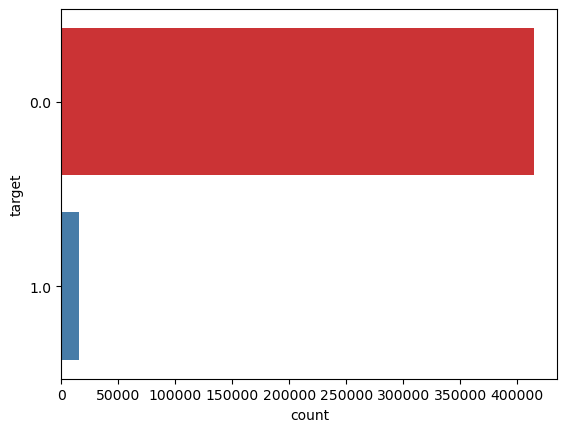

In [29]:
sns.countplot(data = reduced_train, y = config['EDA']['target'], palette = 'Set1')

## Dealing with imbalance with manual estimation class weights

In [50]:
model = LogisticRegression()

# set the weights for the class range
weights = np.linspace(0.0, 0.99, 200)

# create dict for grid_search
param_grid = {'class_weight': [{0: x, 1: 1.0-x} for x in weights]}

In [51]:
temp = pd.concat([ytrain_dummy, xtrain_dummy], axis = 1)
temp[:1]

,target,ps_ind_01_1,ps_ind_01_2,ps_ind_01_3,ps_ind_01_4,ps_ind_01_5,ps_ind_01_6,ps_ind_01_7,ps_ind_01_8,ps_ind_02_cat_1,ps_ind_02_cat_2,ps_ind_02_cat_3,ps_ind_02_cat_4,ps_ind_04_cat_1,ps_ind_04_cat_2,ps_ind_05_cat_1,ps_ind_05_cat_2,ps_ind_05_cat_3,ps_ind_05_cat_4,ps_ind_05_cat_5,ps_ind_05_cat_6,ps_ind_05_cat_7,ps_ind_06_bin_1,ps_ind_06_bin_2,ps_ind_07_bin_1,ps_ind_07_bin_2,ps_ind_08_bin_1,ps_ind_08_bin_2,ps_ind_09_bin_1,ps_ind_09_bin_2,ps_ind_10_bin_1,ps_ind_10_bin_2,ps_ind_11_bin_1,ps_ind_11_bin_2,ps_ind_12_bin_1,ps_ind_12_bin_2,ps_ind_13_bin_1,ps_ind_13_bin_2,ps_ind_14_1,ps_ind_14_2,ps_ind_14_3,ps_ind_14_4,ps_ind_14_5,ps_ind_16_bin_1,ps_ind_16_bin_2,ps_ind_17_bin_1,ps_ind_17_bin_2,ps_ind_18_bin_1,ps_ind_18_bin_2,ps_reg_01_1,ps_reg_01_2,ps_reg_01_3,ps_reg_01_4,ps_reg_01_5,ps_reg_01_6,ps_reg_01_7,ps_reg_01_8,ps_reg_01_9,ps_reg_01_10,ps_car_02_cat_1,ps_car_02_cat_2,ps_car_03_cat_1,ps_car_03_cat_2,ps_car_04_cat_1,ps_car_04_cat_2,ps_car_04_cat_3,ps_car_04_cat_4,ps_car_04_cat_5,ps_car_04_cat_6,ps_car_04_cat_7,ps_car_04_cat_8,ps_car_04_cat_9,ps_car_04_cat_10,ps_car_05_cat_1,ps_car_05_cat_2,ps_car_07_cat_1,ps_car_07_cat_2,ps_car_08_cat_1,ps_car_08_cat_2,ps_car_09_cat_1,ps_car_09_cat_2,ps_car_09_cat_3,ps_car_09_cat_4,ps_car_09_cat_5,ps_car_10_cat_1,ps_car_10_cat_2,ps_car_10_cat_3,ps_car_11_1,ps_car_11_2,ps_car_11_3,ps_car_11_4,ps_calc_01_1,ps_calc_01_2,ps_calc_01_3,ps_calc_01_4,ps_calc_01_5,ps_calc_01_6,ps_calc_01_7,ps_calc_01_8,ps_calc_01_9,ps_calc_01_10,ps_calc_02_1,ps_calc_02_2,ps_calc_02_3,ps_calc_02_4,ps_calc_02_5,ps_calc_02_6,ps_calc_02_7,ps_calc_02_8,ps_calc_02_9,ps_calc_02_10,ps_calc_03_1,ps_calc_03_2,ps_calc_03_3,ps_calc_03_4,ps_calc_03_5,ps_calc_03_6,ps_calc_03_7,ps_calc_03_8,ps_calc_03_9,ps_calc_03_10,ps_calc_04_1,ps_calc_04_2,ps_calc_04_3,ps_calc_04_4,ps_calc_04_5,ps_calc_04_6,ps_calc_05_1,ps_calc_05_2,ps_calc_05_3,ps_calc_05_4,ps_calc_05_5,ps_calc_05_6,ps_calc_05_7,ps_calc_06_1,ps_calc_06_2,ps_calc_06_3,ps_calc_06_4,ps_calc_06_5,ps_calc_06_6,ps_calc_06_7,ps_calc_06_8,ps_calc_06_9,ps_calc_06_10,ps_calc_06_11,ps_calc_07_1,ps_calc_07_2,ps_calc_07_3,ps_calc_07_4,ps_calc_07_5,ps_calc_07_6,ps_calc_07_7,ps_calc_07_8,ps_calc_07_9,ps_calc_07_10,ps_calc_09_1,ps_calc_09_2,ps_calc_09_3,ps_calc_09_4,ps_calc_09_5,ps_calc_09_6,ps_calc_09_7,ps_calc_09_8,ps_calc_12_1,ps_calc_12_2,ps_calc_12_3,ps_calc_12_4,ps_calc_12_5,ps_calc_12_6,ps_calc_12_7,ps_calc_12_8,ps_calc_12_9,ps_calc_12_10,ps_calc_12_11,ps_calc_15_bin_1,ps_calc_15_bin_2,ps_calc_16_bin_1,ps_calc_16_bin_2,ps_calc_17_bin_1,ps_calc_17_bin_2,ps_calc_18_bin_1,ps_calc_18_bin_2,ps_calc_19_bin_1,ps_calc_19_bin_2,ps_calc_20_bin_1,ps_calc_20_bin_2,ps_ind_03,ps_ind_15,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_06_cat,ps_car_11_cat,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_08,ps_calc_10,ps_calc_11,ps_calc_13,ps_calc_14
0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,2.0,7.0,0.5,1.040132,7.0,1.0,64.0,0.316228,0.610209,0.361939,2.828427,9.0,11.0,7.0,6.0,8.0


In [52]:
temp = temp.sample(50000)

xtrain_temp, ytrain_temp = temp.drop(config['EDA']['target'], axis = 1), temp[config['EDA']['target']]

In [53]:
grid = GridSearchCV(model, param_grid = param_grid, cv = StratifiedKFold(n_splits = 3), scoring = 'f1')
grid.fit(xtrain_temp, ytrain_temp )

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid={'class_weight': [{0: 0.0, 1: 1.0},
                                          {0: 0.004974874371859297,
                                           1: 0.9950251256281407},
                                          {0: 0.009949748743718593,
                                           1: 0.9900502512562814},
                                          {0: 0.014924623115577889,
                                           1: 0.9850753768844221},
                                          {0: 0.019899497487437186,
                                           1: 0.9801005025125629},
                                          {0: 0.024874371859...
                                           1: 0.8905527638190954},
                                          {0: 0.11442211055276383,
                                           1: 0.8855778894472361},
                                          {0: 0.11939698492462311,
                                           1: 0.8806030150753769},
                                          {0: 0.12437185929648241,
                                           1: 0.8756281407035176},
                                          {0: 0.1293467336683417,
                                           1: 0.8706532663316583},
                                          {0: 0.13432160804020102,
                                           1: 0.865678391959799},
                                          {0: 0.1392964824120603,
                                           1: 0.8607035175879397},
                                          {0: 0.1442713567839196,
                                           1: 0.8557286432160804}, ...]},
             scoring='f1')

In [54]:
grid.best_score_, grid.best_params_

(0.0977704453137029,
 {'class_weight': {0: 0.054723618090452265, 1: 0.9452763819095478}})

In [55]:
config['Model_Selection']['selected_class_weight'] = grid.best_params_['class_weight']

Text(0.5, 1.0, 'Weight for class 1')

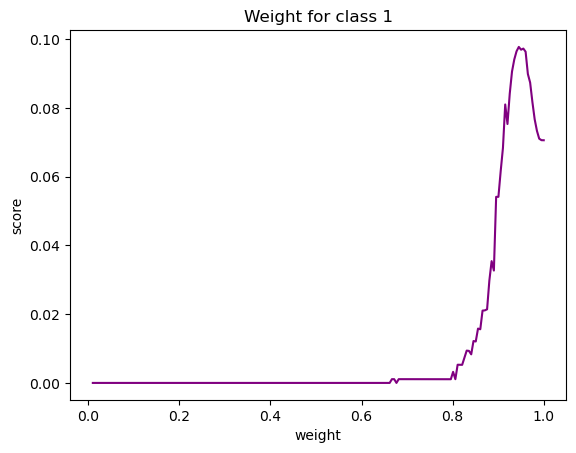

In [56]:
# grab the score and weight for class 1

weight_data = pd.DataFrame({'score':grid.cv_results_['mean_test_score'],
             'weight': 1 - weights})

sns.lineplot(data = weight_data, y = 'score', x = 'weight', color = 'purple')
plt.title('Weight for class 1')

In [57]:
config['Model_Selection']['Experiments'] = {}

# Experiment 0

1. Missing Values: Drop
2. Encoding: One-Hot
3. Transformation: None
4. Outliers: None
5. Scaling: None
6. Resampling: None
7. Feature Selection: None

In [58]:
categorical0, numerical0, xtrain0, ytrain0 = split_data_by_type(reduced_train, config['EDA']['target'])

In [59]:
# dropping missing values

In [60]:
## drop columns that have more than 60% null values
nulls = xtrain0.isnull().mean()

to_drop = nulls[nulls>=0.6].index.tolist()

xtrain0 = xtrain0.drop(to_drop, axis = 1)

to_drop

['ps_car_03_cat']

In [61]:
# drop missing values

temp0 = pd.concat([xtrain0, ytrain0], axis = 1)

temp0 = temp0.dropna()

categorical0, numerical0, xtrain0, ytrain0 = split_data_by_type(temp0, config['EDA']['target'])

In [62]:
# onehot - pipeline

cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

pipeline0 = ColumnTransformer([
    ('cat_pipeline', cat_pipeline, categorical0)
], verbose_feature_names_out = False, remainder = 'passthrough')

In [63]:
xtrain0 = pipeline0.fit_transform(xtrain0)

Starting evaluation.....


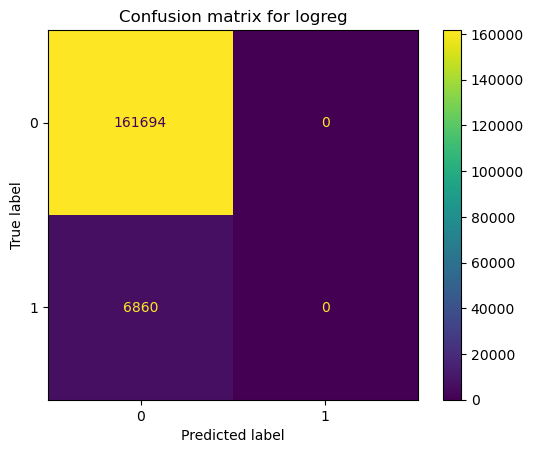

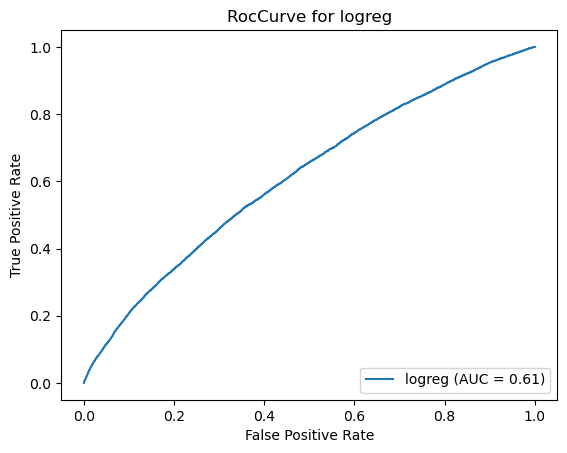

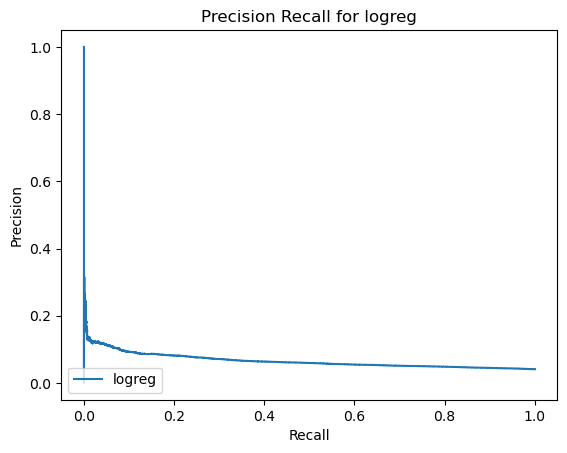

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    161694
         1.0       0.00      0.00      0.00      6860

    accuracy                           0.96    168554
   macro avg       0.48      0.50      0.49    168554
weighted avg       0.92      0.96      0.94    168554



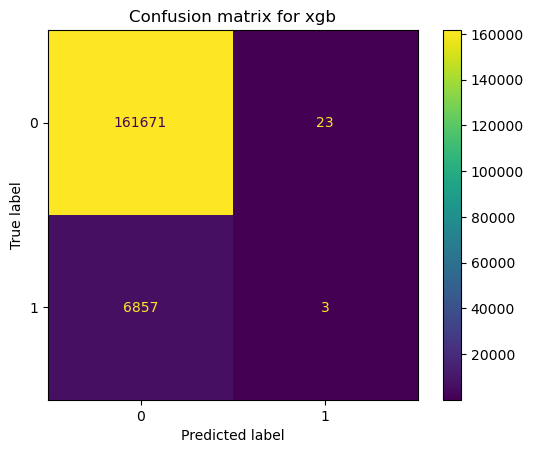

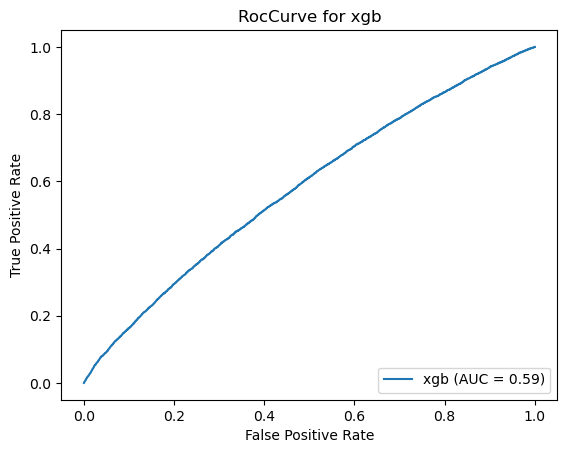

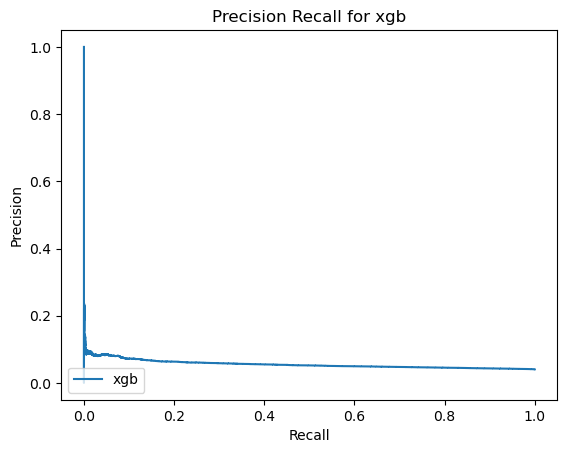

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    161694
         1.0       0.12      0.00      0.00      6860

    accuracy                           0.96    168554
   macro avg       0.54      0.50      0.49    168554
weighted avg       0.92      0.96      0.94    168554



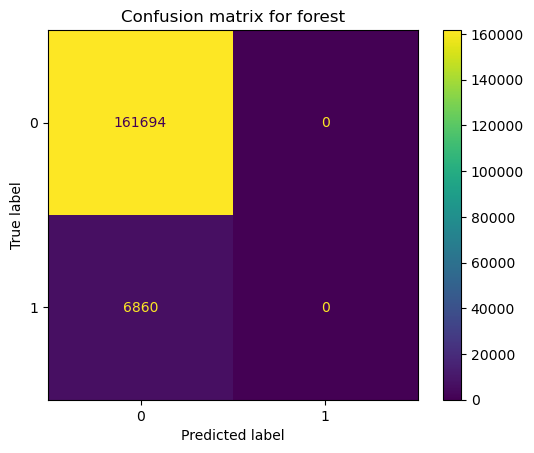

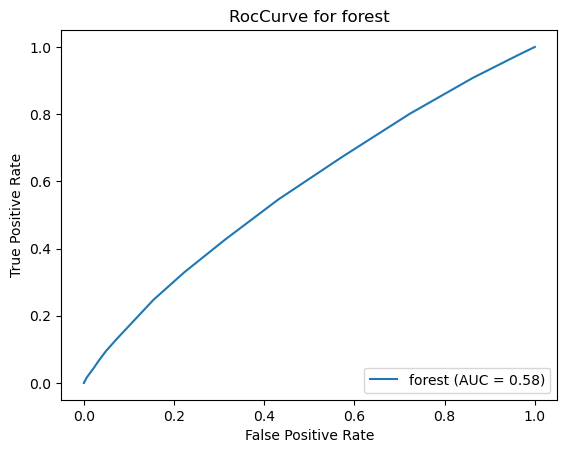

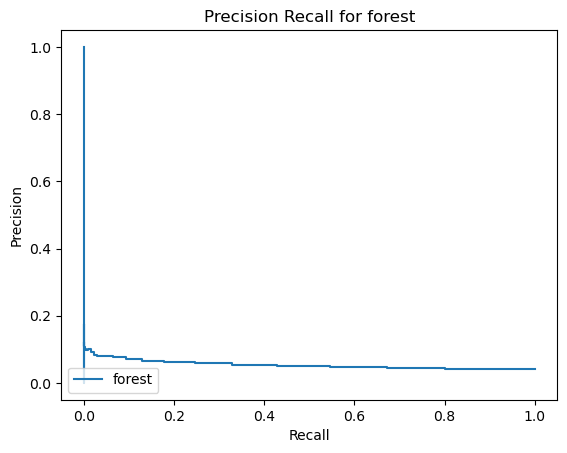

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    161694
         1.0       0.00      0.00      0.00      6860

    accuracy                           0.96    168554
   macro avg       0.48      0.50      0.49    168554
weighted avg       0.92      0.96      0.94    168554

[LightGBM] [Info] Number of positive: 4573, number of negative: 107796
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1506
[LightGBM] [Info] Number of data points in the train set: 112369, number of used features: 192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.040696 -> initscore=-3.160071
[LightGBM] [Info] Start training from score -3.160071
[LightGBM] [Info] Number of positive: 4573, number of negative: 107796
[LightGBM] [Info] Auto-choosing row-wise m

[LightGBM] [Info] Number of positive: 4573, number of negative: 107796
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1505
[LightGBM] [Info] Number of data points in the train set: 112369, number of used features: 192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.040696 -> initscore=-3.160071
[LightGBM] [Info] Start training from score -3.160071
[LightGBM] [Info] Number of positive: 4573, number of negative: 107796
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1507
[LightGBM] [Info] Number of data points in the train set: 112369, number of used features: 192
[LightGBM] [In

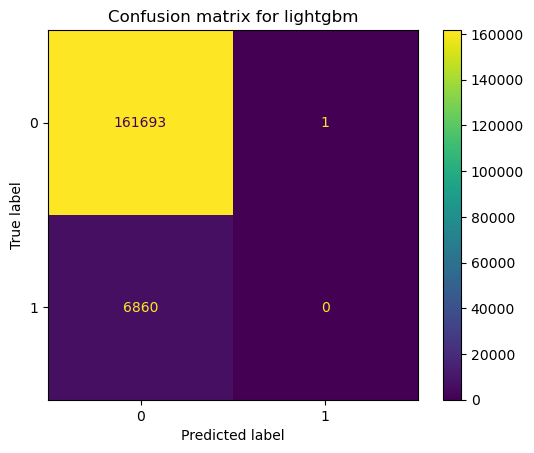

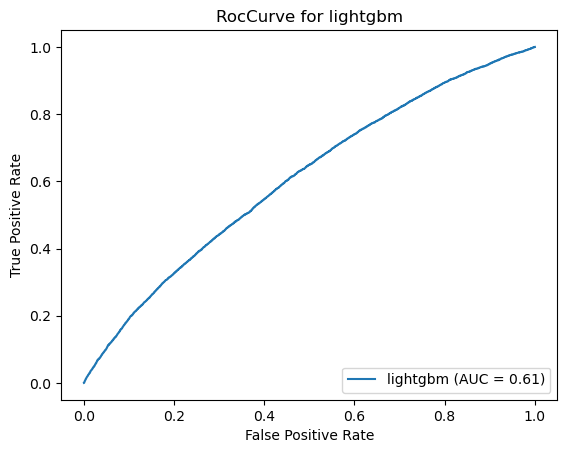

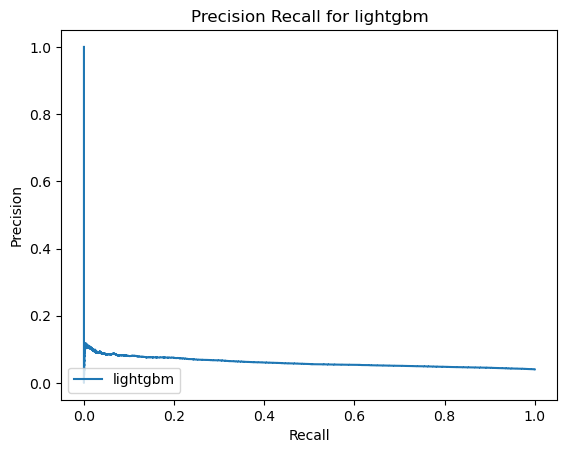

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    161694
         1.0       0.00      0.00      0.00      6860

    accuracy                           0.96    168554
   macro avg       0.48      0.50      0.49    168554
weighted avg       0.92      0.96      0.94    168554



In [64]:
metrics0 = model_evaluation(load_models(), xtrain0, ytrain0, 0)

In [145]:
config['Model_Selection']['Experiments']['Experiment_0'] = metrics0.to_dict()

In [66]:
metrics0

,Model,AUC,F1,Accuracy,Precision,Recall
0,logreg_0,0.614539,0.000000,0.959301,0.000000,0.000000
1,xgb_0,0.585037,0.000580,0.959129,0.039216,0.000875
2,forest_0,0.583881,0.000000,0.959301,0.000000,0.000000
3,lightgbm_0,0.611276,0.000292,0.959295,0.166667,0.000000


# Experiment 1

1. Missing Values: Simple
2. Encoding: One-Hot
3. Transformation: Log
4. Outliers: Winsorize(0.95-0.05)
5. Scaling: StandardScaler
6. Resampling: SMOTE
7. Feature Selection: Enet Coefs

In [67]:
categorical1, numerical1, xtrain1, ytrain1 = split_data_by_type(reduced_train, config['EDA']['target'])

In [69]:
cat_pipeline1 = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),  
    ('encoder', OneHotEncoder()),

])


num_pipeline1 = Pipeline([
    ('transformer', FunctionTransformer(np.log1p)),
    ('imputer', SimpleImputer(strategy = 'median')), 
    ('func_winsorize',  FunctionTransformer(winsorize)),
    ('scaler', StandardScaler()),

])


pipeline1 = create_pipeline(num_pipeline1, numerical1, cat_pipeline1, categorical1)

xtrain1 = pipeline1.fit_transform(xtrain1)

In [70]:
# resampling

In [71]:
smote = SMOTE()

In [72]:
xtrain1_samp, ytrain1_samp = smote.fit_resample(xtrain1, ytrain1)

In [73]:
# Enet coef

In [74]:
enet = ElasticNet(l1_ratio = 0.5, alpha = 0.01)

enet.fit(xtrain1_samp, ytrain1_samp)

ElasticNet(alpha=0.01)

In [75]:
selected_columns1 = dict(zip(xtrain1.columns.tolist(), enet.coef_.tolist()))

In [76]:
selected_columns1 = [column for column, value in selected_columns1.items() if value >= 0]
print(len(selected_columns1))

xtrain1_samp = xtrain1_samp[selected_columns1]

99


Starting evaluation.....


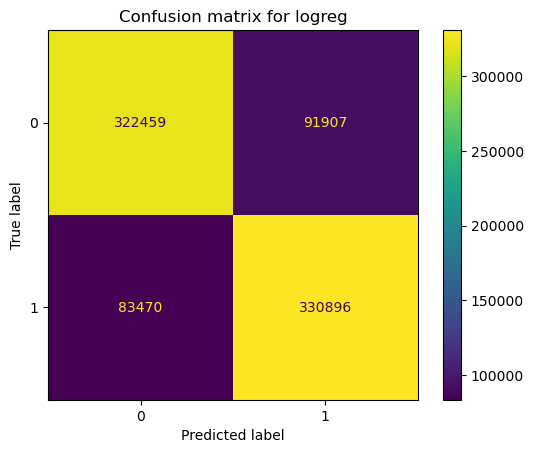

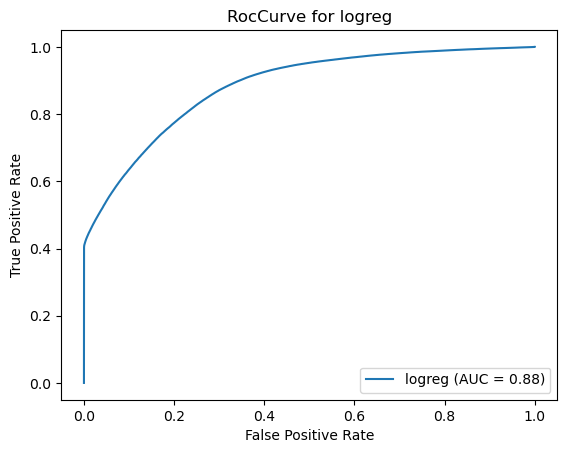

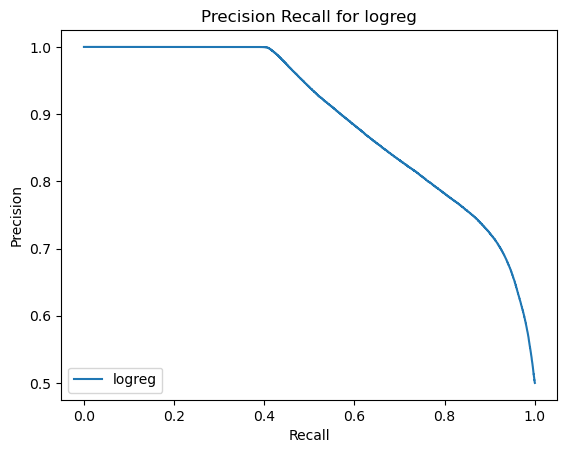

              precision    recall  f1-score   support

         0.0       0.79      0.78      0.79    414366
         1.0       0.78      0.80      0.79    414366

    accuracy                           0.79    828732
   macro avg       0.79      0.79      0.79    828732
weighted avg       0.79      0.79      0.79    828732



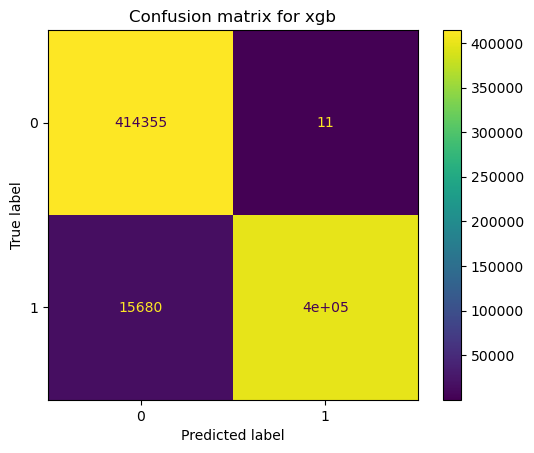

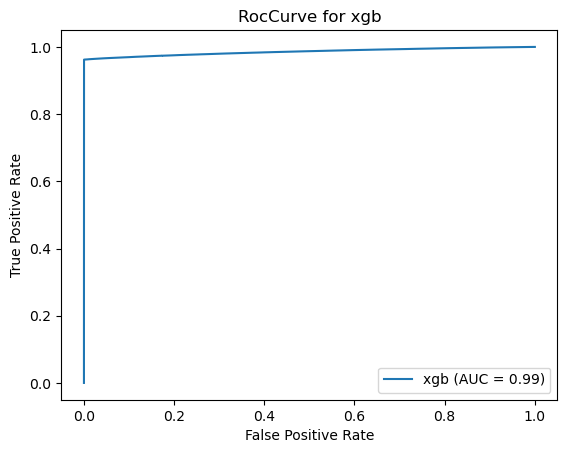

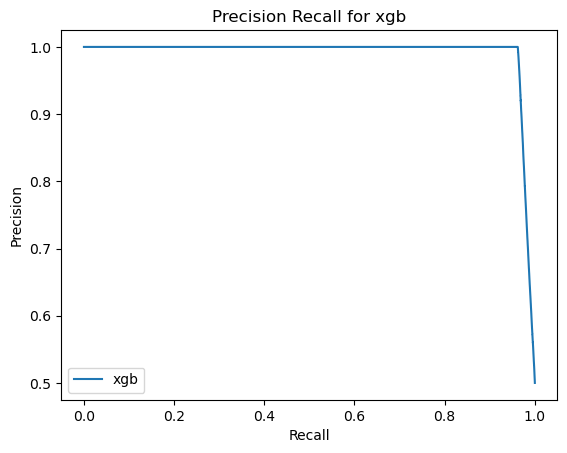

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    414366
         1.0       1.00      0.96      0.98    414366

    accuracy                           0.98    828732
   macro avg       0.98      0.98      0.98    828732
weighted avg       0.98      0.98      0.98    828732



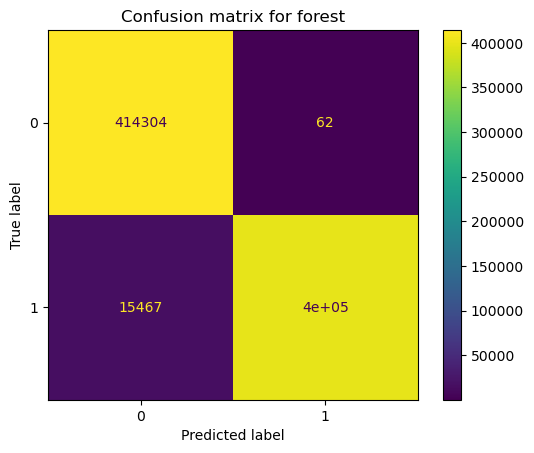

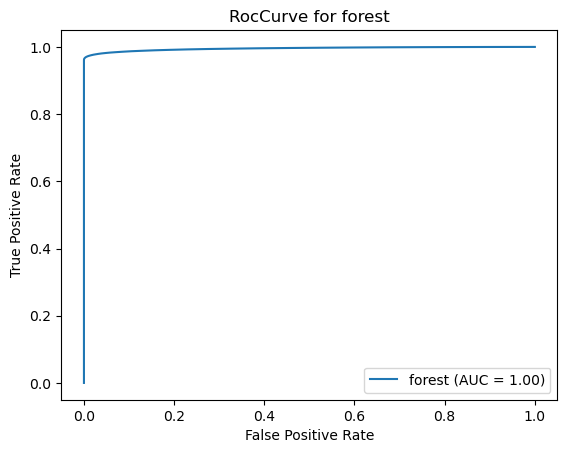

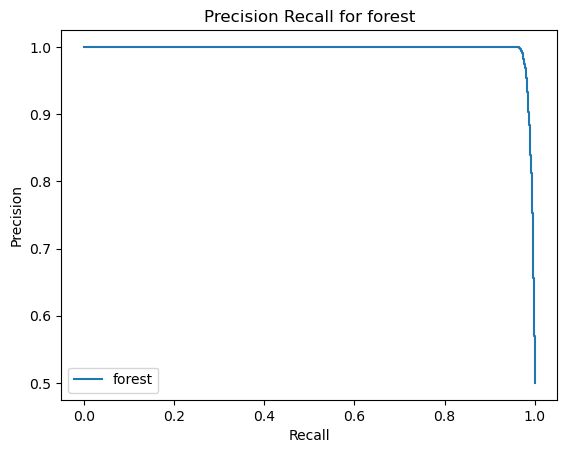

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    414366
         1.0       1.00      0.96      0.98    414366

    accuracy                           0.98    828732
   macro avg       0.98      0.98      0.98    828732
weighted avg       0.98      0.98      0.98    828732

[LightGBM] [Info] Number of positive: 276244, number of negative: 276244
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.109549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4234
[LightGBM] [Info] Number of data points in the train set: 552488, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 276244, number of negative: 276244
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132766

[LightGBM] [Info] Number of positive: 276244, number of negative: 276244
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.157236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4234
[LightGBM] [Info] Number of data points in the train set: 552488, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 276244, number of negative: 276244
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4232
[LightGBM] [Info] Number of data points in the train set: 552488, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initsco

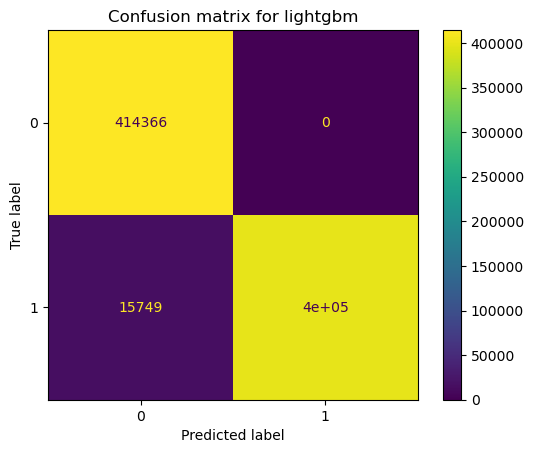

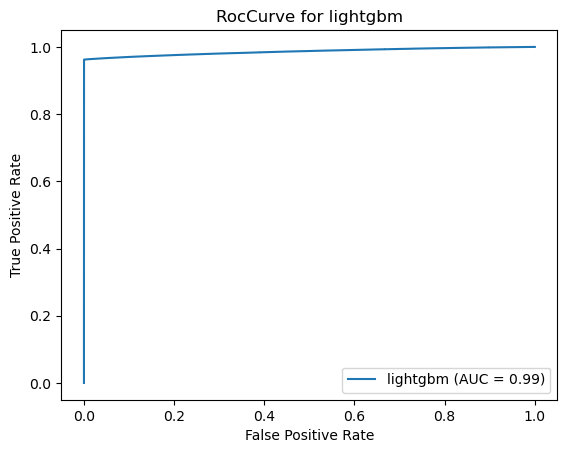

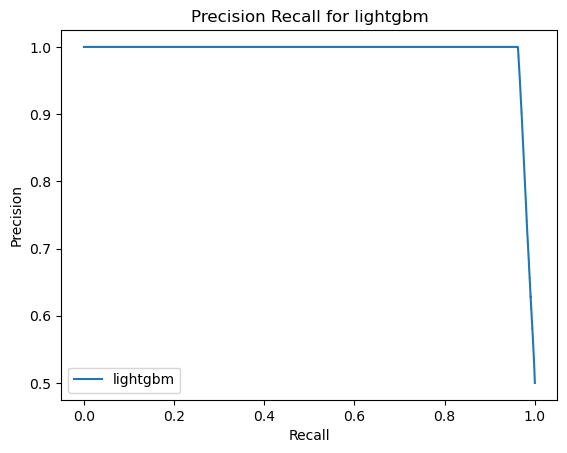

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    414366
         1.0       1.00      0.96      0.98    414366

    accuracy                           0.98    828732
   macro avg       0.98      0.98      0.98    828732
weighted avg       0.98      0.98      0.98    828732



,Model,AUC,F1,Accuracy,Precision,Recall
0,logreg_1,0.882607,0.790274,0.788351,0.782856,0.802923
1,xgb_1,0.985485,0.980687,0.981060,0.999985,0.962145
2,forest_1,0.995125,0.980847,0.981242,0.999827,0.962622
3,lightgbm_1,0.985966,0.980629,0.981014,1.000000,0.961976


In [77]:
metrics1 = model_evaluation(load_models(),xtrain1_samp, ytrain1_samp, 1)

metrics1

In [144]:
config['Model_Selection']['Experiments']['Experiment_1'] = metrics1.to_dict()

# Experiment 2

1. Missing Values: Percentile Imputation
2. Encoding: Ordinal
3. Transformation: Sqrt
4. Outliers: Winsorize(0.95-0.05)
5. Scaling: RobustScaler
6. Resampling: ADASYN
7. Feature Selection: SelectFromModel

In [79]:
categorical2, numerical2, xtrain2, ytrain2 = split_data_by_type(reduced_train, config['EDA']['target'])

In [80]:
cat_pipeline2 = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),  
    ('encoder', OrdinalEncoder()),

])


num_pipeline2 = Pipeline([
    ('transformer', FunctionTransformer(np.sqrt)),
    ('imputer', FunctionTransformer(percentile_imputer)), 
    ('winsorize',  FunctionTransformer(winsorize)),
    ('scaler', RobustScaler()),

])

pipeline2 = create_pipeline(num_pipeline2, numerical2, cat_pipeline2, categorical2)

xtrain2 = pipeline2.fit_transform(xtrain2)

In [81]:
# adasyn

adasyn = ADASYN()

xtrain2, ytrain2 = adasyn.fit_resample(xtrain2, ytrain2)

### select from model

What does SelectFromModel do?
SelectFromModel accepts a threshold parameter and will select the features whose importance (defined by the coefficients) are above this threshold. Since we want to select only 2 features, we will set this threshold slightly above the coefficient of third most important feature.

In [82]:
rf = RandomForestClassifier()

select = SelectFromModel(rf, threshold=0.0001).fit(xtrain2, ytrain2)

In [83]:
selected_columns2 = xtrain2.columns[select.get_support()]

len(selected_columns2)

54

In [84]:
xtrain2 = xtrain2[selected_columns2]

Starting evaluation.....


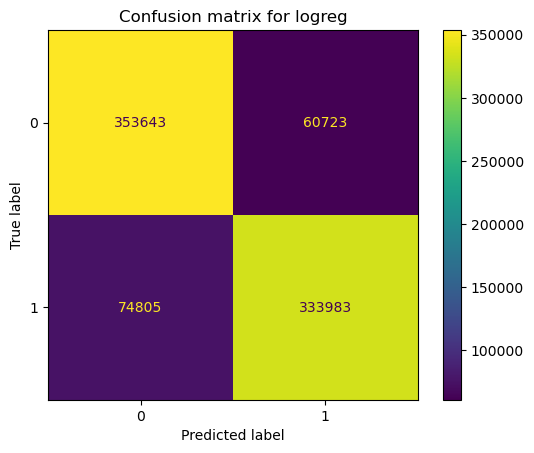

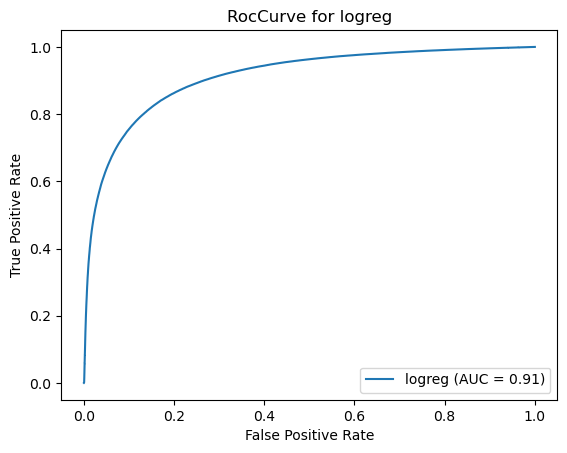

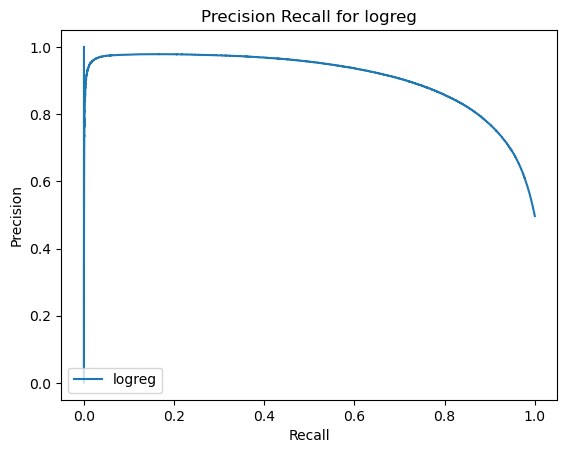

              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84    414366
         1.0       0.85      0.82      0.83    408788

    accuracy                           0.84    823154
   macro avg       0.84      0.84      0.84    823154
weighted avg       0.84      0.84      0.84    823154



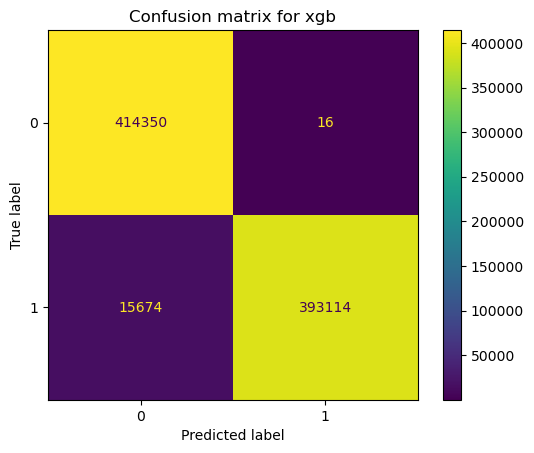

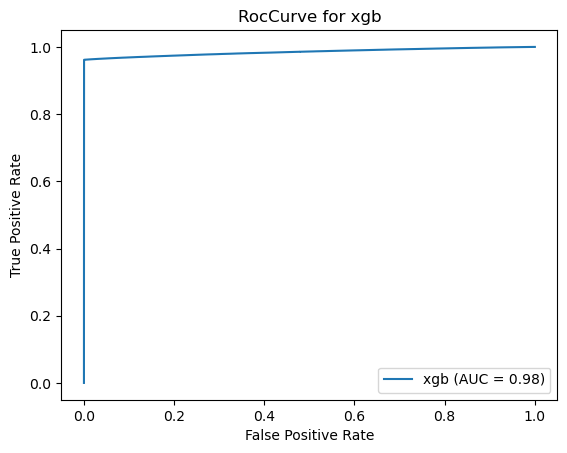

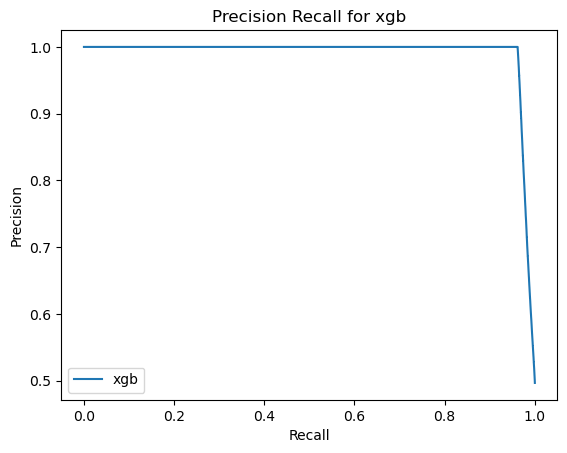

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    414366
         1.0       1.00      0.96      0.98    408788

    accuracy                           0.98    823154
   macro avg       0.98      0.98      0.98    823154
weighted avg       0.98      0.98      0.98    823154



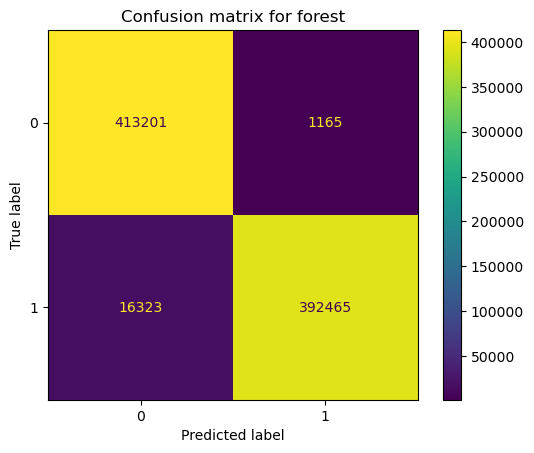

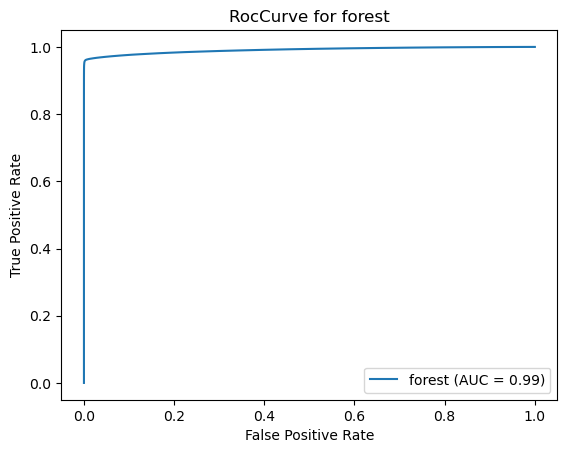

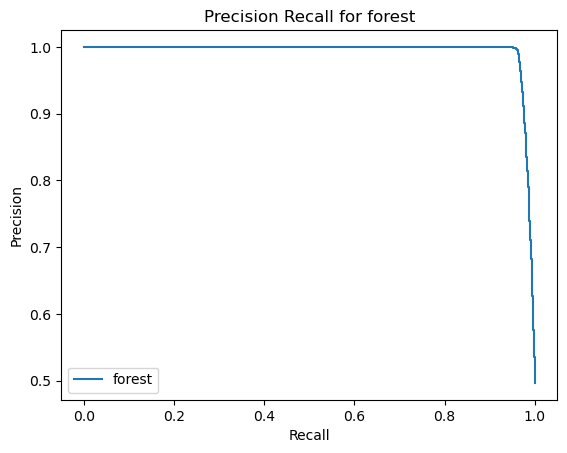

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    414366
         1.0       1.00      0.96      0.98    408788

    accuracy                           0.98    823154
   macro avg       0.98      0.98      0.98    823154
weighted avg       0.98      0.98      0.98    823154

[LightGBM] [Info] Number of positive: 272525, number of negative: 276244
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4295
[LightGBM] [Info] Number of data points in the train set: 548769, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496612 -> initscore=-0.013554
[LightGBM] [Info] Start training from score -0.013554
[LightGBM] [Info] Number of positive: 272525, number of negative: 276244
[LightGBM] [Info] Auto-choosing row-wis

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4294
[LightGBM] [Info] Number of data points in the train set: 548770, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496612 -> initscore=-0.013551
[LightGBM] [Info] Start training from score -0.013551
[LightGBM] [Info] Number of positive: 272525, number of negative: 276244
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4294
[LightGBM] [Info] Number of data points in the train set: 548769, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496612 -> initscore=-0.013554
[Ligh

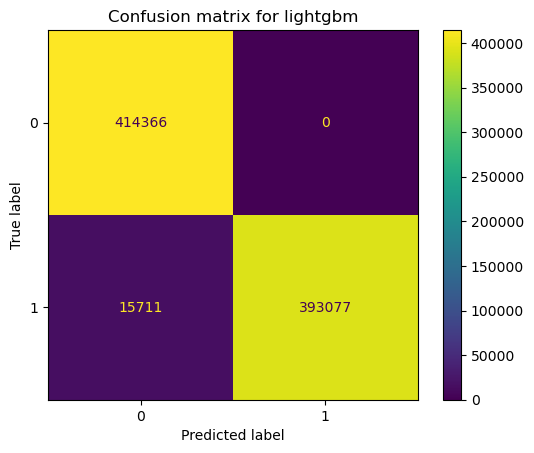

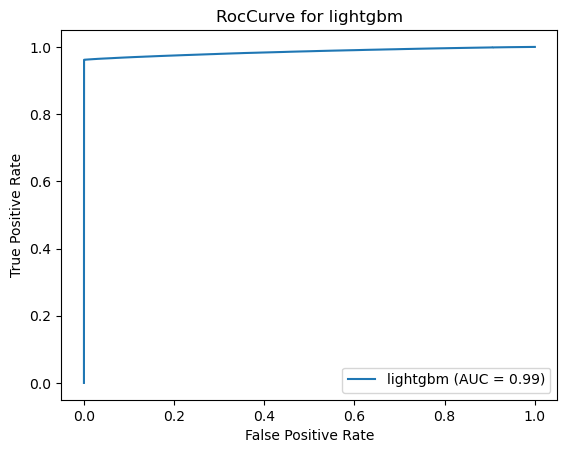

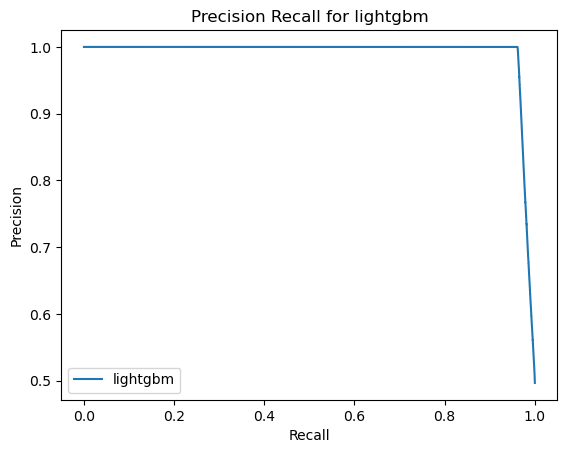

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    414366
         1.0       1.00      0.96      0.98    408788

    accuracy                           0.98    823154
   macro avg       0.98      0.98      0.98    823154
weighted avg       0.98      0.98      0.98    823154



,Model,AUC,F1,Accuracy,Precision,Recall
0,logreg_2,0.909261,0.832957,0.831977,0.846776,0.822825
1,xgb_2,0.984951,0.980427,0.980922,0.999941,0.961635
2,forest_2,0.990658,0.978107,0.978828,0.997179,0.960040
3,lightgbm_2,0.985317,0.980399,0.980898,1.000000,0.961540


In [85]:
metrics2 = model_evaluation(load_models(), xtrain2, ytrain2, 2)

metrics2

In [143]:
config['Model_Selection']['Experiments']['Experiment_2'] = metrics2.to_dict()

# Experiment 3

1. Missing Values: Random Sample
2. Encoding: Count
3. Transformation: Polynomial
4. Outliers: Winsorize(0.95 - 0.05)
5. Scaling: MaxAbsScaler
6. Resampling: Class weight(balanced)
7. Feature Selection: Fclassification

In [86]:
categorical3, numerical3, xtrain3, ytrain3 = split_data_by_type(reduced_train, config['EDA']['target'])

In [89]:
cat_pipeline3 = Pipeline([
    ('imputer', FunctionTransformer(random_sample_imputer)),  
    ('encoder', FunctionTransformer(count_encoder)),

])


num_pipeline3 = Pipeline([
    ('imputer', FunctionTransformer(random_sample_imputer)),
    ('transformer', PolynomialFeatures()),
    ('winsorize',  FunctionTransformer(winsorize)),
    ('scaler', MaxAbsScaler()),

])

pipeline3 = create_pipeline(num_pipeline3, numerical3, cat_pipeline3, categorical3)

xtrain3 = pipeline3.fit_transform(xtrain3)

#### f_classification

The hypotheses for the F-test of the overall significance are as follows: Null hypothesis: The fit of the intercept-only model and your model are equal. Alternative hypothesis: The fit of the intercept-only model is significantly reduced compared to your model


In [90]:
value, pvalue = f_classif(xtrain3, ytrain3)

values_3 = dict(zip(xtrain3.columns, pvalue))

selected_columns3 = [column for column, value in values_3.items() if value<=0.05]

len(selected_columns3)

149

In [91]:
xtrain3 = xtrain3[selected_columns3]

Starting evaluation.....


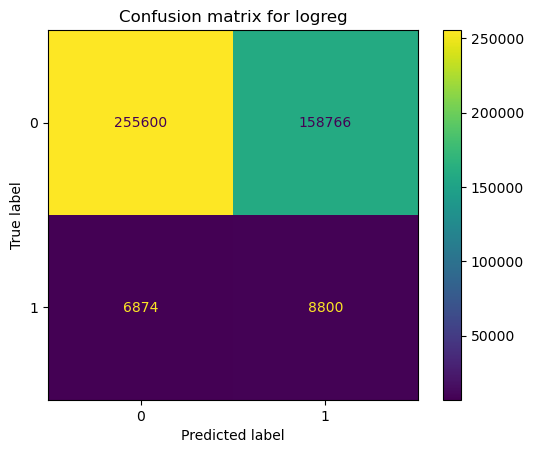

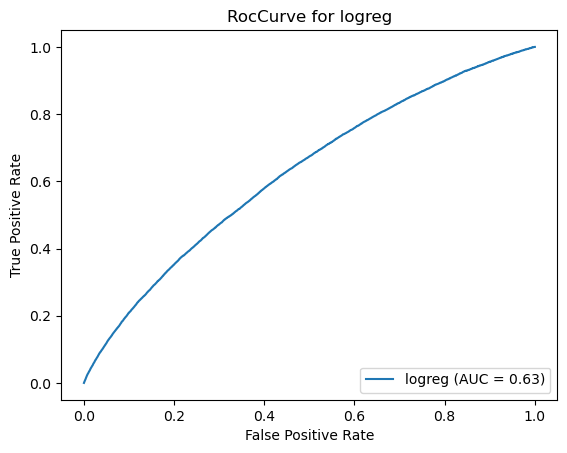

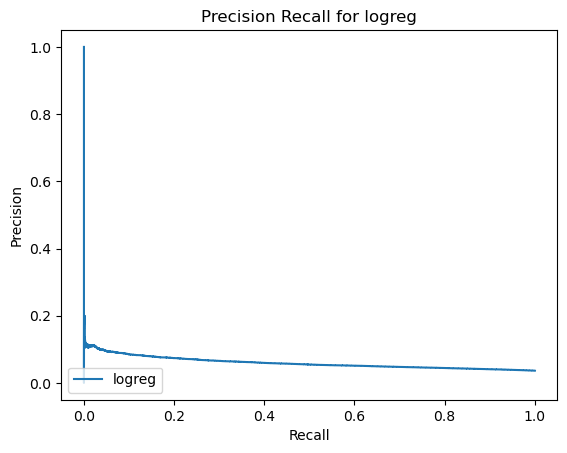

              precision    recall  f1-score   support

         0.0       0.97      0.62      0.76    414366
         1.0       0.05      0.56      0.10     15674

    accuracy                           0.61    430040
   macro avg       0.51      0.59      0.43    430040
weighted avg       0.94      0.61      0.73    430040

[20:33:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "class_weight" } are not used.

[20:35:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "class_weight" } are not used.

[20:37:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "class_weight" } are not used.

[20:39:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu

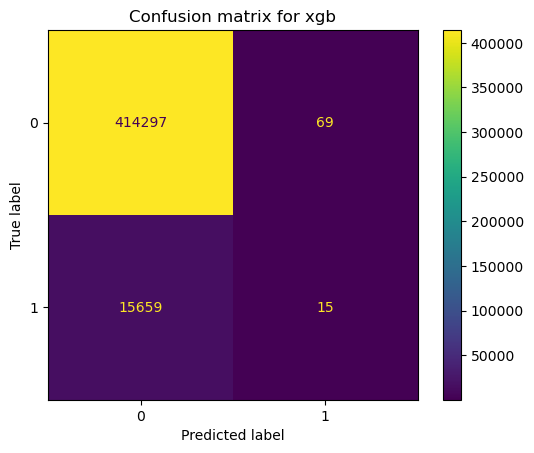

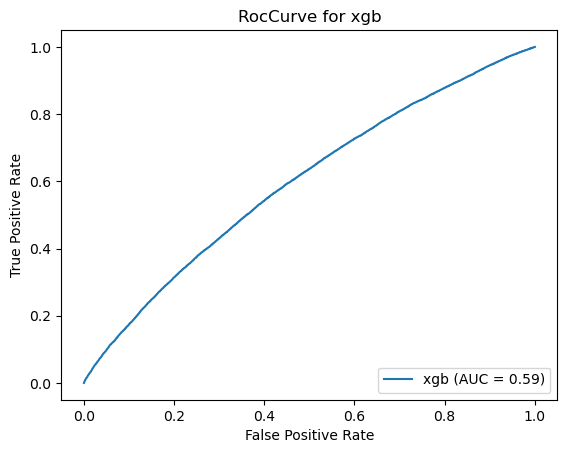

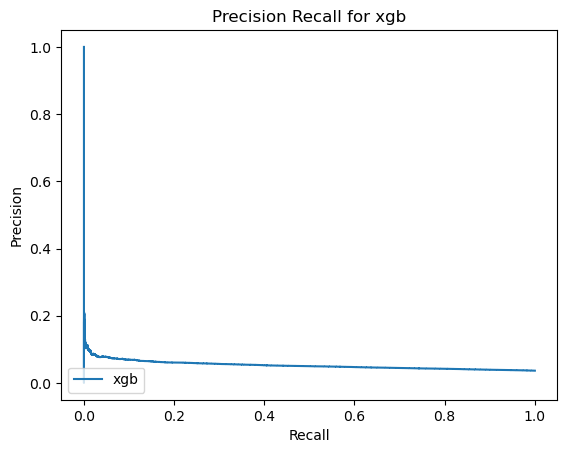

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    414366
         1.0       0.18      0.00      0.00     15674

    accuracy                           0.96    430040
   macro avg       0.57      0.50      0.49    430040
weighted avg       0.93      0.96      0.95    430040



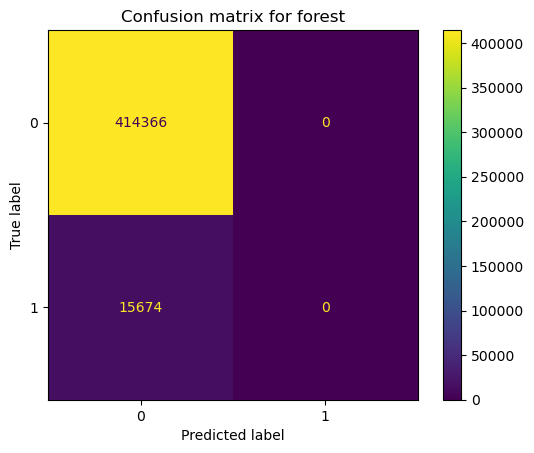

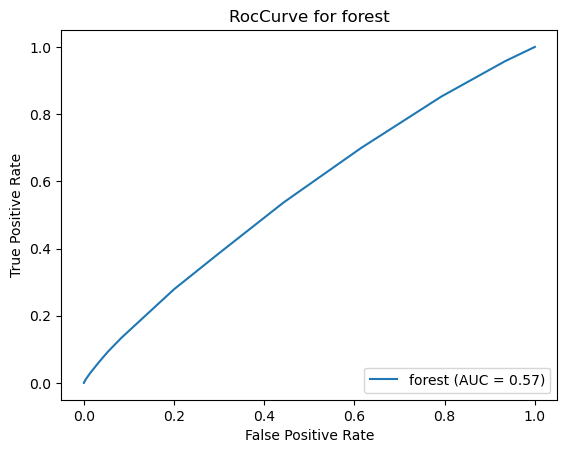

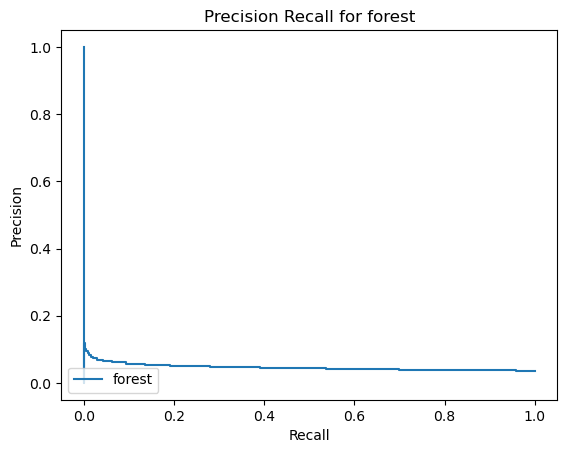

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    414366
         1.0       0.00      0.00      0.00     15674

    accuracy                           0.96    430040
   macro avg       0.48      0.50      0.49    430040
weighted avg       0.93      0.96      0.95    430040

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 10449, number of negative: 276244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.216988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20317
[LightGBM] [Info] Number of data points in the train set: 286693, number of used features: 149
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 10450, number of negative: 276244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.279073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20318
[LightGBM] [Info] Number of data points in the train set: 286694, number of used features: 149
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 10449, number of negative: 276244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.259235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20322
[LightGBM] [Info] Number of data points in the train set: 286693, number 

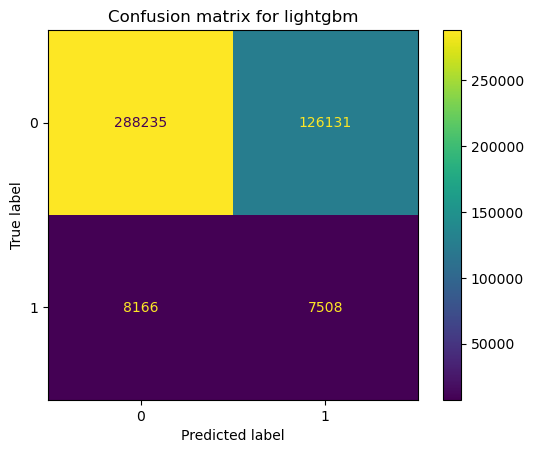

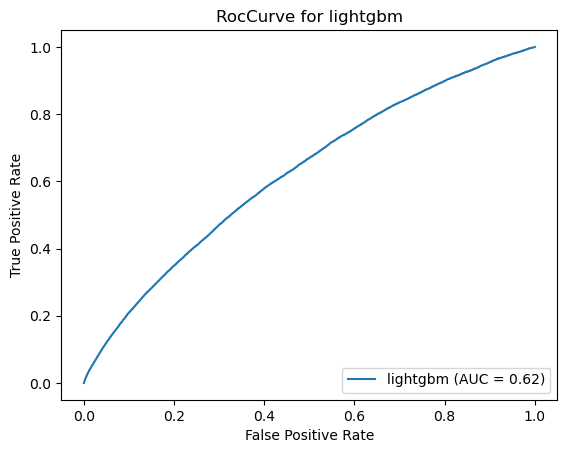

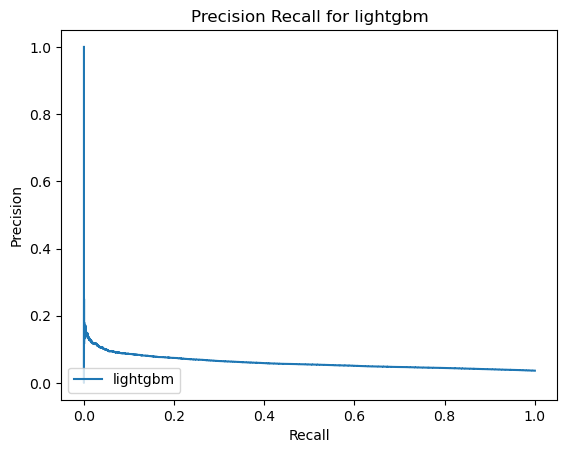

              precision    recall  f1-score   support

         0.0       0.97      0.70      0.81    414366
         1.0       0.06      0.48      0.10     15674

    accuracy                           0.69    430040
   macro avg       0.51      0.59      0.46    430040
weighted avg       0.94      0.69      0.79    430040



,Model,AUC,F1,Accuracy,Precision,Recall
0,logreg_3,0.626489,0.096476,0.616196,0.052580,0.560993
1,xgb_3,0.594048,0.000381,0.963422,0.130051,0.000638
2,forest_3,0.569163,0.000000,0.963552,0.000000,0.000000
3,lightgbm_3,0.621516,0.099984,0.685497,0.055452,0.481051


In [92]:
metrics3 = model_evaluation(load_models(class_weight = 'balanced'), xtrain3, ytrain3, 3)

metrics3

In [142]:
config['Model_Selection']['Experiments']['Experiment_3'] = metrics3.to_dict()

# Experiment 4

1. Missing Values: MICE
2. Encoding: One-Hot
3. Transformation: Log
4. Outliers: Winsorize(0.95-0.05)
5. Scaling: StandardScaler
6. Resampling: Class weight(manual)
7. Feature Selection: Permutation Importance

In [111]:
categorical4, numerical4, xtrain4, ytrain4 = split_data_by_type(reduced_train, config['EDA']['target'])

In [112]:
cat_pipeline4 = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),  
    ('encoder', OneHotEncoder()),

])


num_pipeline4 = Pipeline([
    ('transformer', FunctionTransformer(np.log1p)),
    ('imputer', SimpleImputer(strategy = 'median')), 
    ('winsorize',  FunctionTransformer(winsorize)),
    ('scaler', StandardScaler())
     ])

pipeline4 = create_pipeline(num_pipeline4, numerical4, cat_pipeline4, categorical4)

xtrain4 = pipeline4.fit_transform(xtrain4)

####  Permutation feature importance¶
Permutation feature importance is a model inspection technique that measures the contribution of each feature to a fitted model’s statistical performance on a given tabular dataset. This technique is particularly useful for non-linear or opaque estimators, and involves randomly shuffling the values of a single feature and observing the resulting degradation of the model’s score [1]. By breaking the relationship between the feature and the target, we determine how much the model relies on such particular feature.



In [113]:
x_val  = validation.drop(target, axis = 1)
y_val = validation[target]

x_val = pipeline4.transform(x_val)

In [114]:
model = lgb.LGBMClassifier().fit(xtrain4, ytrain4)

r = permutation_importance(model, x_val, y_val,
                            n_repeats=10,
                            random_state=0)

[LightGBM] [Info] Number of positive: 15674, number of negative: 414366
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.146928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1386
[LightGBM] [Info] Number of data points in the train set: 430040, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036448 -> initscore=-3.274746
[LightGBM] [Info] Start training from score -3.274746


In [133]:
model.score(x_val, y_val,)

0.9635525102121492

In [135]:
imp = dict(zip(xtrain4.columns, r.importances_mean))

selected_columns4 = [column for column, value in imp.items() if abs(value) > 0]

In [136]:
len(selected_columns4)

12

In [137]:
xtrain4 = xtrain4[selected_columns4]

Starting evaluation.....


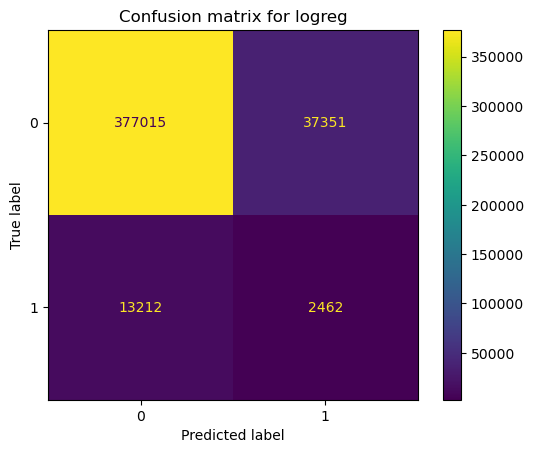

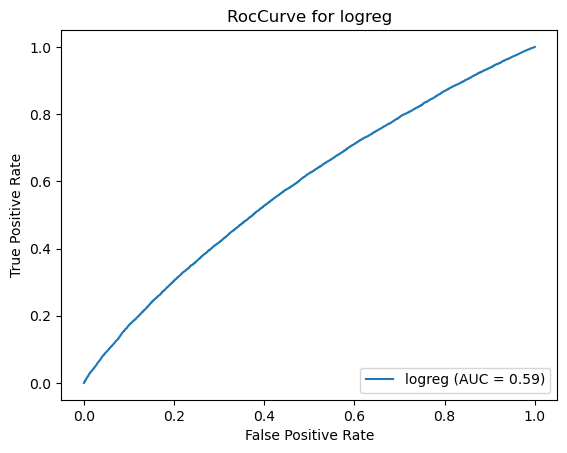

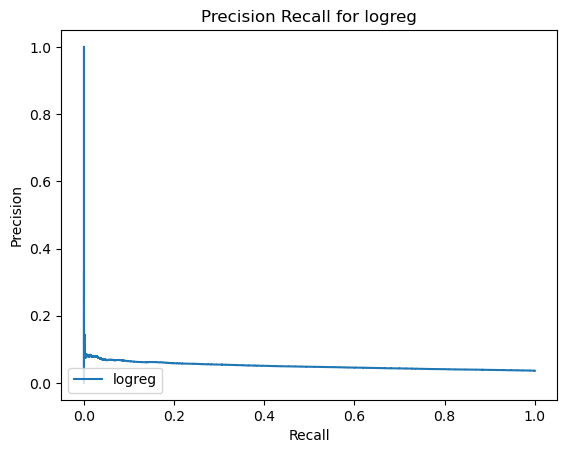

              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    414366
         1.0       0.06      0.16      0.09     15674

    accuracy                           0.88    430040
   macro avg       0.51      0.53      0.51    430040
weighted avg       0.93      0.88      0.91    430040

[09:27:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "class_weight" } are not used.

[09:27:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "class_weight" } are not used.

[09:28:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "class_weight" } are not used.

[09:28:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu

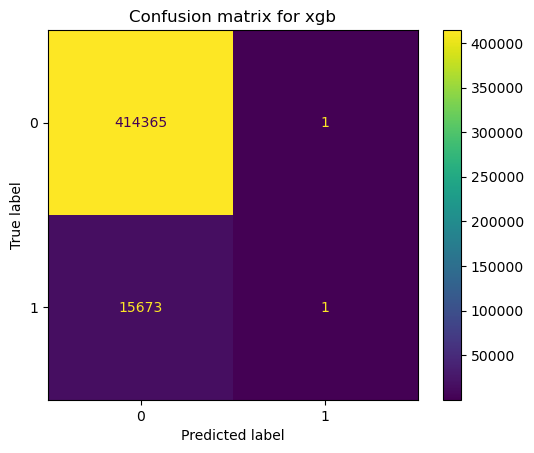

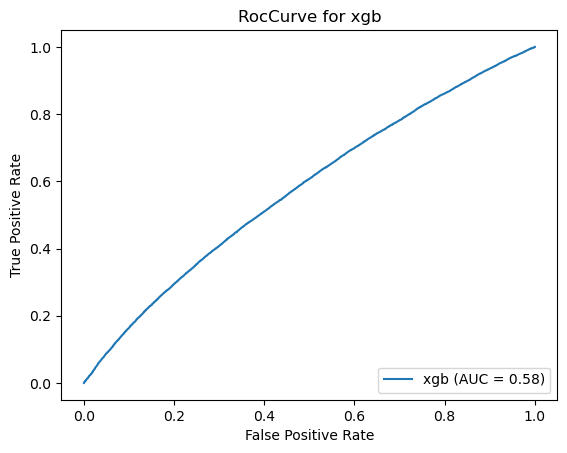

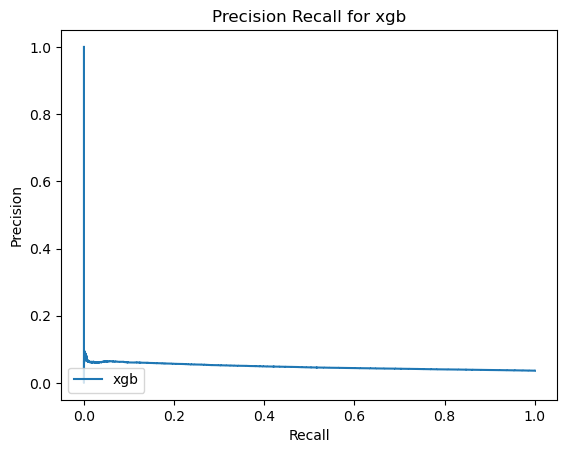

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    414366
         1.0       0.50      0.00      0.00     15674

    accuracy                           0.96    430040
   macro avg       0.73      0.50      0.49    430040
weighted avg       0.95      0.96      0.95    430040



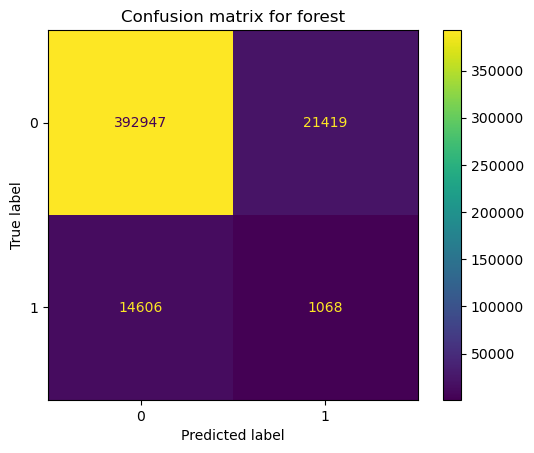

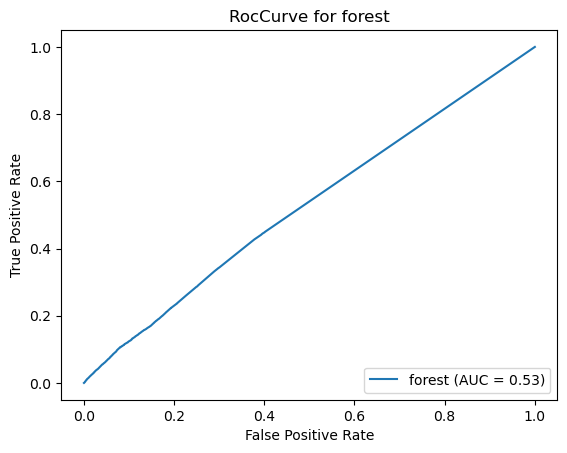

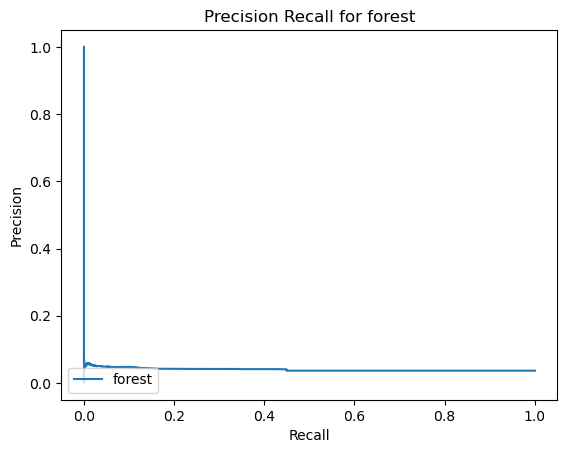

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96    414366
         1.0       0.05      0.07      0.06     15674

    accuracy                           0.92    430040
   macro avg       0.51      0.51      0.51    430040
weighted avg       0.93      0.92      0.92    430040

[LightGBM] [Info] Number of positive: 10449, number of negative: 276244
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 300
[LightGBM] [Info] Number of data points in the train set: 286693, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.395178 -> initscore=-0.425596
[LightGBM] [Info] Start training from score -0.425596
[LightGBM] [Info] Number of positive: 10449, number of negative: 276244
[LightGBM] [Info] Auto-choosing row-wise m

[LightGBM] [Info] Number of positive: 10449, number of negative: 276244
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 300
[LightGBM] [Info] Number of data points in the train set: 286693, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.395178 -> initscore=-0.425596
[LightGBM] [Info] Start training from score -0.425596
[LightGBM] [Info] Number of positive: 10449, number of negative: 276244
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 300
[LightGBM] [Info] Number of data points in the train set: 286693, number of used features: 12
[LightGBM] [Info

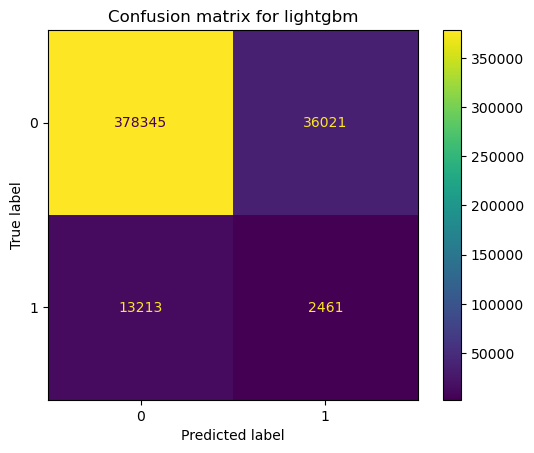

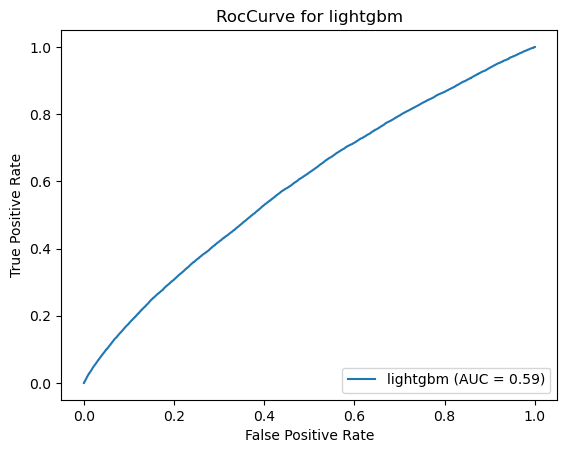

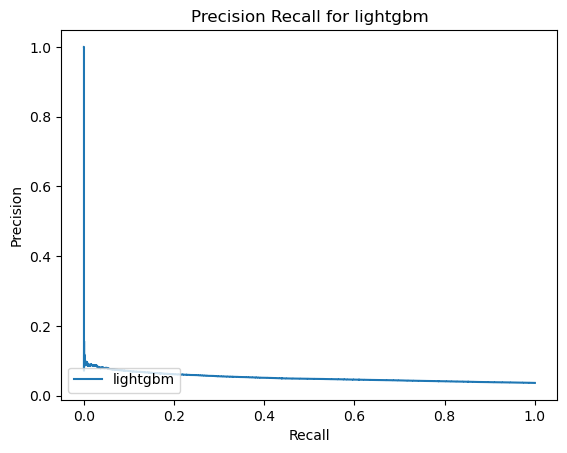

              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    414366
         1.0       0.06      0.16      0.09     15674

    accuracy                           0.89    430040
   macro avg       0.52      0.54      0.51    430040
weighted avg       0.93      0.89      0.91    430040



,Model,AUC,F1,Accuracy,Precision,Recall
0,logreg_4,0.586608,0.089447,0.882102,0.061873,0.156437
1,xgb_4,0.578027,0.000000,0.963550,0.000000,0.000000
2,forest_4,0.528160,0.057314,0.917524,0.046402,0.067883
3,lightgbm_4,0.589401,0.089901,0.886683,0.064431,0.156374


In [138]:
metrics4 = model_evaluation(load_models(class_weight = grid.best_params_['class_weight']), xtrain4, ytrain4, 4)

metrics4

In [195]:
config['Model_Selection']['Experiments']['Experiment_4'] = metrics4.to_dict()

# Experiment 5

1. Missing Values: Percentile Imputation
2. Encoding: Ordinal
3. Transformation: Sqrt
4. Outliers: Winsorize(0.95-0.05)
5. Scaling: RobustScaler
6. Resampling: Undersampling
7. Feature Selection: SelectFromModel

In [196]:
categorical5, numerical5, xtrain5, ytrain5 = split_data_by_type(reduced_train, config['EDA']['target'])

In [198]:
cat_pipeline5 = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),  
    ('encoder', OrdinalEncoder()),

])


num_pipeline5 = Pipeline([
    ('transformer', FunctionTransformer(np.sqrt)),
    ('imputer', FunctionTransformer(percentile_imputer)), 
    ('winsorize',  FunctionTransformer(winsorize)),
    ('scaler', RobustScaler()),

])

pipeline5 = create_pipeline(num_pipeline5, numerical5, cat_pipeline5, categorical5)

In [200]:
xtrain5 = pipeline5.fit_transform(xtrain5)

In [201]:
undersampler = RandomUnderSampler()

xtrain5, ytrain5 = undersampler.fit_resample(xtrain5, ytrain5)

In [202]:
rf = RandomForestClassifier()

select = SelectFromModel(rf, threshold=0.001).fit(xtrain5, ytrain5)

selected_columns5 = xtrain5.columns[select.get_support()]

len(selected_columns5)

51

In [203]:
xtrain5 = xtrain5[selected_columns5]

Starting evaluation.....


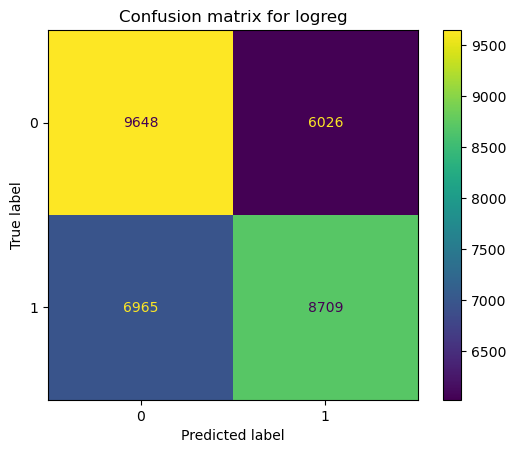

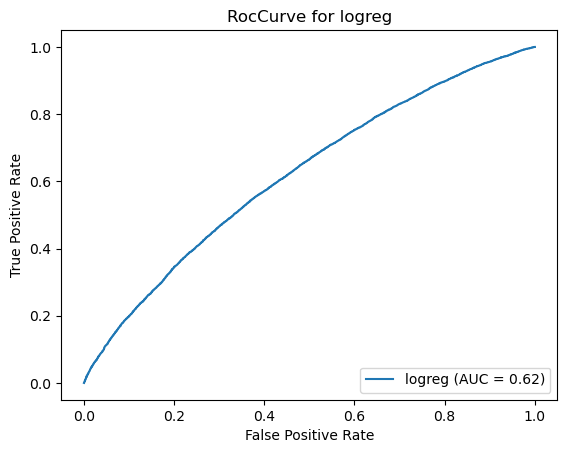

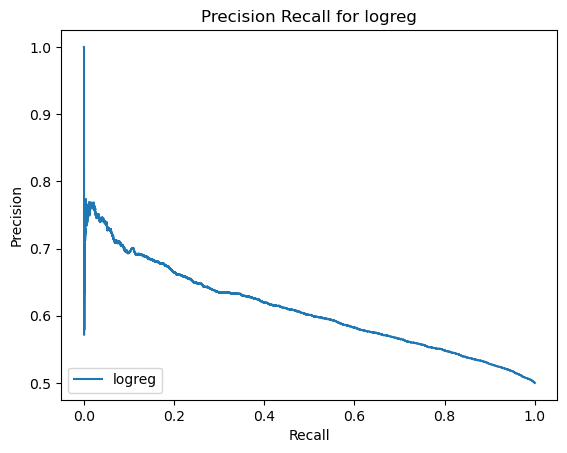

              precision    recall  f1-score   support

         0.0       0.58      0.62      0.60     15674
         1.0       0.59      0.56      0.57     15674

    accuracy                           0.59     31348
   macro avg       0.59      0.59      0.59     31348
weighted avg       0.59      0.59      0.59     31348



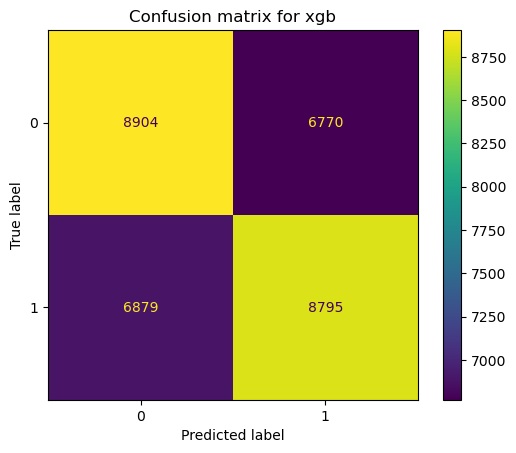

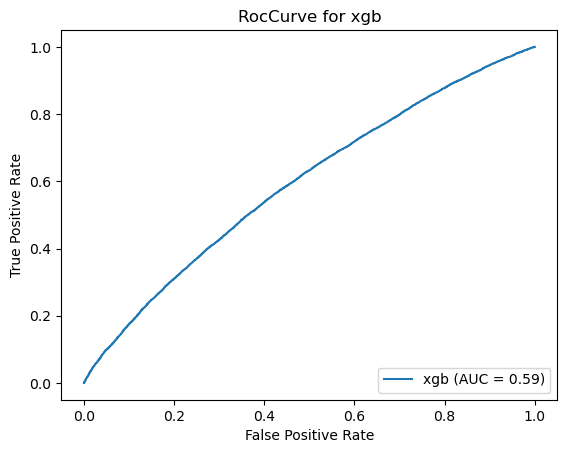

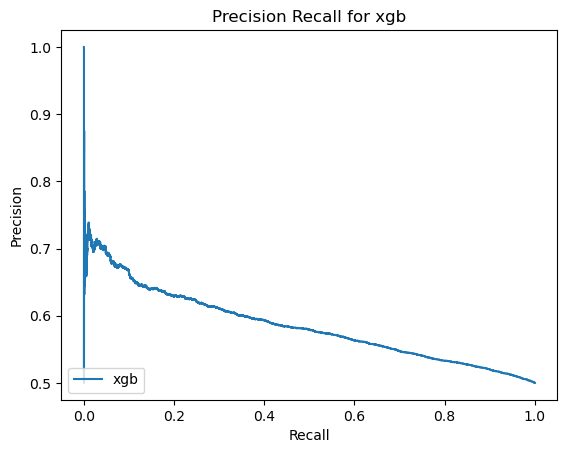

              precision    recall  f1-score   support

         0.0       0.56      0.57      0.57     15674
         1.0       0.57      0.56      0.56     15674

    accuracy                           0.56     31348
   macro avg       0.56      0.56      0.56     31348
weighted avg       0.56      0.56      0.56     31348



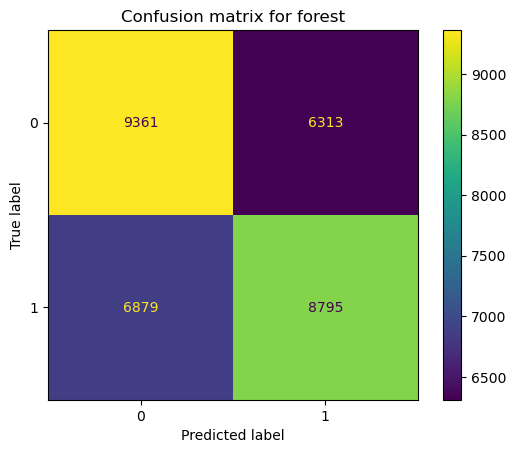

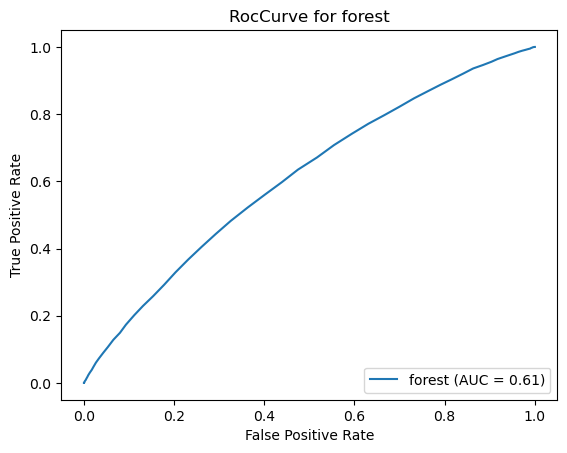

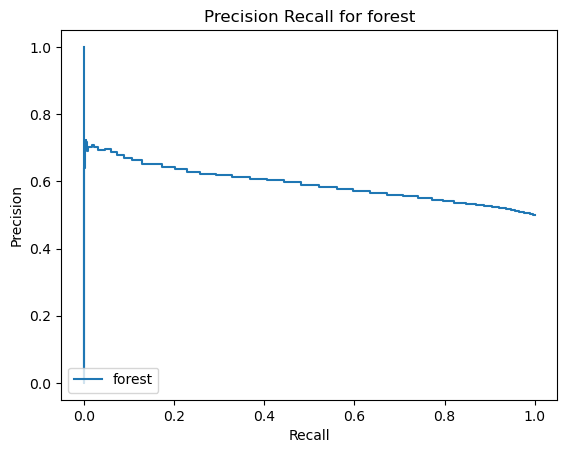

              precision    recall  f1-score   support

         0.0       0.58      0.60      0.59     15674
         1.0       0.58      0.56      0.57     15674

    accuracy                           0.58     31348
   macro avg       0.58      0.58      0.58     31348
weighted avg       0.58      0.58      0.58     31348

[LightGBM] [Info] Number of positive: 10449, number of negative: 10449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1203
[LightGBM] [Info] Number of data points in the train set: 20898, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 10450, number of negative: 10449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004107 seco

[LightGBM] [Info] Number of positive: 10449, number of negative: 10449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1203
[LightGBM] [Info] Number of data points in the train set: 20898, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 10450, number of negative: 10449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 20899, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500024 -> initscore=0.0

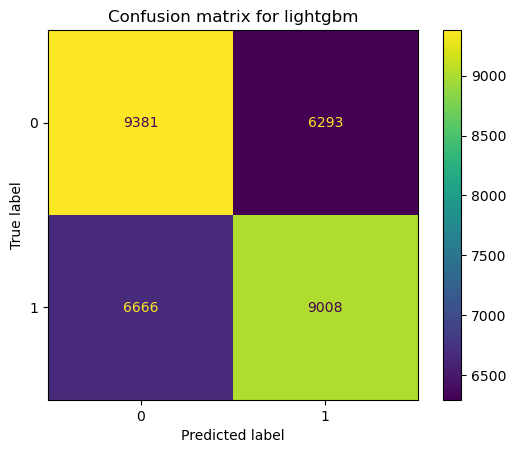

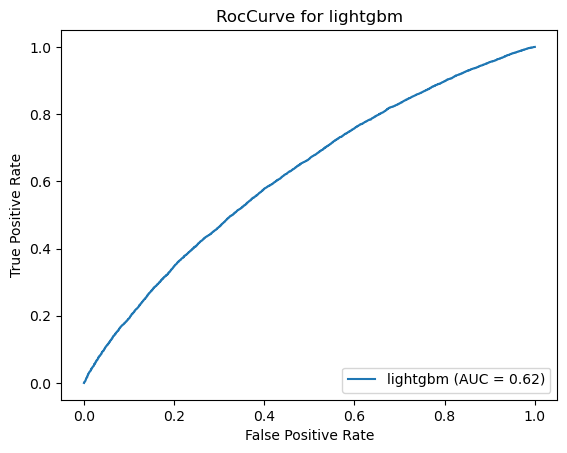

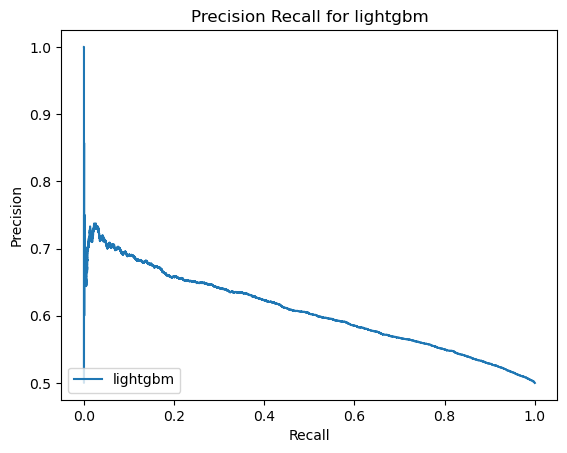

              precision    recall  f1-score   support

         0.0       0.58      0.60      0.59     15674
         1.0       0.59      0.57      0.58     15674

    accuracy                           0.59     31348
   macro avg       0.59      0.59      0.59     31348
weighted avg       0.59      0.59      0.59     31348



,Model,AUC,F1,Accuracy,Precision,Recall
0,logreg_5,0.620592,0.571609,0.584248,0.590218,0.552890
1,xgb_5,0.593150,0.561078,0.564215,0.559609,0.557229
2,forest_5,0.606649,0.570110,0.580420,0.579619,0.565076
3,lightgbm_5,0.622014,0.584871,0.588714,0.591031,0.574774


In [204]:
metrics5 = model_evaluation(load_models(), xtrain5, ytrain5, 5)

metrics5

In [205]:
config['Model_Selection']['Experiments']['Experiment_5'] = metrics5.to_dict()

# Results

In [206]:
results = pd.concat([metrics_dummy, metrics0, metrics1, metrics2, metrics3, metrics4, metrics5]).sort_values(['AUC', 'F1'], ascending = False)

results

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


,Model,AUC,F1,Accuracy,Precision,Recall
2,forest_1,0.995125,0.980847,0.981242,0.999827,0.962622
2,forest_2,0.990658,0.978107,0.978828,0.997179,0.960040
3,lightgbm_1,0.985966,0.980629,0.981014,1.000000,0.961976
1,xgb_1,0.985485,0.980687,0.981060,0.999985,0.962145
3,lightgbm_2,0.985317,0.980399,0.980898,1.000000,0.961540
1,xgb_2,0.984951,0.980427,0.980922,0.999941,0.961635
0,logreg_2,0.909261,0.832957,0.831977,0.846776,0.822825
0,logreg_1,0.882607,0.790274,0.788351,0.782856,0.802923
0,logreg_3,0.626489,0.096476,0.616196,0.052580,0.560993
3,lightgbm_5,0.622014,0.584871,0.588714,0.591031,0.574774


In [207]:
config['Model_Selection']['Experiments']['Results'] = results.to_dict()

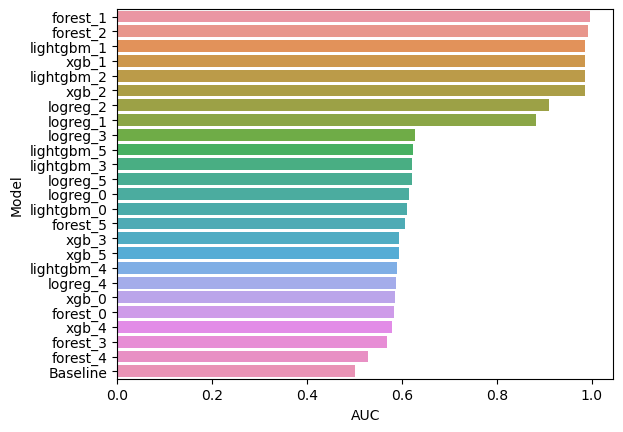

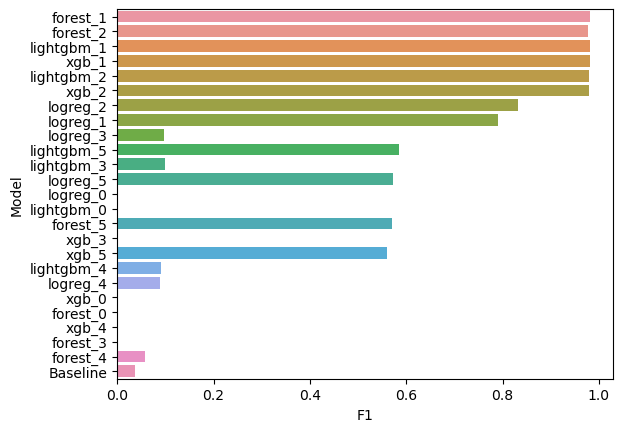

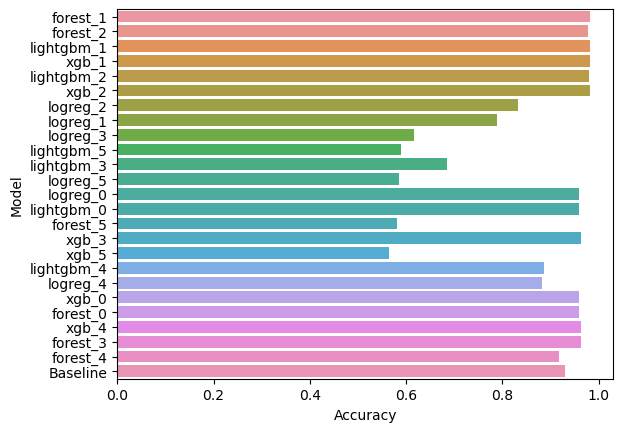

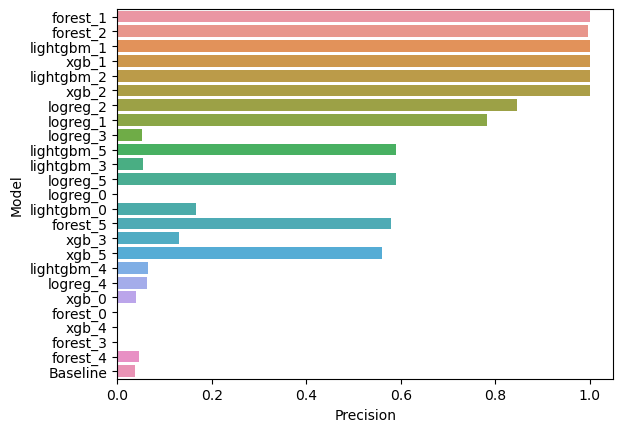

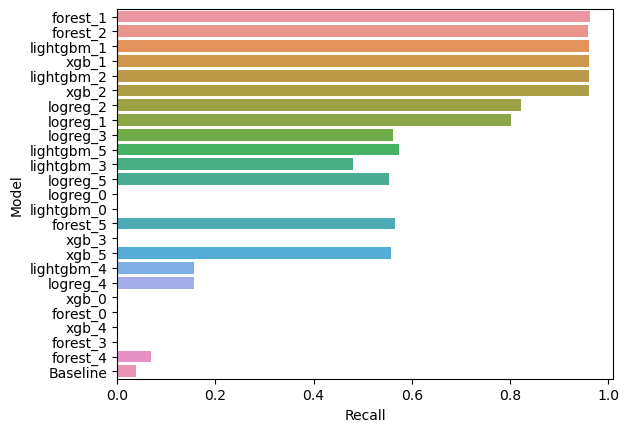

In [208]:
for metric in results.columns[1:]:
    
    plt.figure()
            
    sns.barplot(data = results, x = metric, y  = 'Model',)

# Write to Config

In [209]:
# Serializing json
json_object = json.dumps(config, indent=4)
 
# Writing to sample.json
with open("C:/Users/Oamen/OneDrive/Documents/DATA PROJECTS/Insurance_claim_prediction_porto/config.json", "w") as outfile:
    outfile.write(json_object)